# <center>Trabajo de Fin De Máster (TFM)<center>

**Nombre y apellidos:** David Santiago Pérez Barrios

**Usuario VIU:** david.perezbarrios@alumnos.viu.es

---
## 0. Importe de librerias a utilizar
---

In [ ]:
!pip install numpy==1.23.5 Cython==0.29.36 scikit-learn==1.2.2
#!pip install pmdarima==2.0.4
#!pip install arch

In [ ]:
#!pip install tensorflow scikit-learn
#!pip install --upgrade numpy tensorflow
#!pip install protobuf==3.20.*
#!pip install --upgrade numpy==1.24.3 protobuf==3.20.*
#!pip install tensorflow==2.12.0

In [ ]:
# Importe de librerias a utilizar en todo el trabajo #
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
from scipy.stats import shapiro, jarque_bera, normaltest, anderson
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose # Descomposicion de la serie
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF y PACF
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm
#from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model # Modelo GARCH
from sklearn.linear_model import LinearRegression # Regresión Lineal
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Semilla aleatoria arbitraria y constante a incluir en los algoritmos para que los experimentos sean siempre reproducibles #
seed = 2499

---
## 1. Preparación de los datos
---

### 1.1. Recolección de los datos

Se hará uso de la API de Yahoo Finance para poder descargar los datos históricos de cierre diarios.

In [ ]:
# Se crea una funcion para poder descargar los datos de los indicadores bursatiles desde Yahoo Finance #
def descargar_datos(activos, fecha_inicio, fecha_fin = None):

    """
    Se hace la descarga de datos históricos diarios desde Yahoo Finance por medio de la API de Yahoo Finance.

    Parámetros de ingreso:
    - activos: lista de símbolos correspondientes a indicadores bursátiles de Yahoo Finance
    - fecha_inicio: fecha de inicio en formato 'YYYY-MM-DD'
    - fecha_fin: fecha de fin en formato 'YYYY-MM-DD' (opcional, si no se coloca, toma la fecha actual)

    Retorna:
    - Un diccionario de DataFrames con los datos de cada activo
    """

    datos = {}
    for activo in activos:
        print(f"Descargando datos de {activo}...")
        datos[activo] = yf.download(activo, start = fecha_inicio, end = fecha_fin, progress = False)
    return datos

In [ ]:
# Lista de los indicadores a analizar #
activos = [
    "^NDX",         # NASDAQ-100 (principal)
    "QQQ",          # Invesco QQQ ETF
    "MSFT",         # Microsoft
    "AAPL",         # Apple
    "^SOX",         # Índice de Semiconductores de Filadelfia
    "TSLA",         # Tesla
    "^TNX",         # Tasa de bonos a 10 años
    "DX-Y.NYB",     # Índice del dólar
    "^VXN",         # Índice de Volatilidad del NASDAQ
    "AMZN",         # Amazon
    "BTC-USD"       # Bitcoin en USD
]

# Fecha de inicio y fin de consulta #
fecha_inicio = "2015-01-01"
fecha_fin = "2025-04-01"

# Descargar los datos #
data_descargada = descargar_datos(activos, fecha_inicio, fecha_fin)

Descargando datos de ^NDX...
YF.download() has changed argument auto_adjust default to True
Descargando datos de QQQ...
Descargando datos de MSFT...
Descargando datos de AAPL...
Descargando datos de ^SOX...
Descargando datos de TSLA...
Descargando datos de ^TNX...
Descargando datos de DX-Y.NYB...
Descargando datos de ^VXN...
Descargando datos de AMZN...
Descargando datos de BTC-USD...


### 1.2. Tratamiento de valores faltantes

In [ ]:
data = pd.DataFrame()

# Se constuye un DataFrame con solo la columna 'Close' de cada activo descargado #
for activos, df in data_descargada.items():
  if 'Close' in df.columns:
    data[activos] = df['Close']

In [ ]:
# Se calcula la cantidad de valores faltantes por variable #
missing_counts = data.isnull().sum()

# Se calcula la proporción de valores faltantes #
missing_proportion = (missing_counts / len(data)).round(4)
missing_table = pd.DataFrame({
    'Missing Values': missing_counts,
    'Proportion': missing_proportion
})

# Se filtra sólo por variables que tienen valores faltantes #
missing_table = missing_table[missing_table['Missing Values'] > 0]
missing_table.sort_values(by='Missing Values', ascending=False, inplace=True)

print(missing_table)

          Missing Values  Proportion
DX-Y.NYB               2      0.0008
^TNX                   1      0.0004
^VXN                   1      0.0004


#### 1.2.1. Eliminación de variables con 10% o más de datos faltantes

In [ ]:
# Se filtran las columnas con 10% o más de valores faltantes #
cols_to_drop = missing_table[missing_proportion >= 0.10].index

# Se eliminan dichas columnas del DataFrame #
df_clean = data.drop(columns=cols_to_drop)

# Se muestran las columnas eliminadas #
print("Variables eliminadas por tener ≥10% de valores faltantes:")
print(list(cols_to_drop))

Variables eliminadas por tener ≥10% de valores faltantes:
[]


<ipython-input-9-7d8d234fd7bc>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cols_to_drop = missing_table[missing_proportion >= 0.10].index


#### 1.2.2. Interpolación lineal para datos faltantes < 10%

In [ ]:
# Se calcula la cantidad de valores faltantes por variable #
missing_counts2 = df_clean.isnull().sum()

# Se calcula la proporción de valores faltantes #
missing_proportion2 = (missing_counts2 / len(df_clean)).round(4)
missing_table2 = pd.DataFrame({
    'Missing Values': missing_counts2,
    'Proportion': missing_proportion2
})

# Se filtra sólo por variables que tienen valores faltantes #
missing_table2 = missing_table2[missing_table2['Missing Values'] > 0]
missing_table2.sort_values(by='Missing Values', ascending=False, inplace=True)

print(missing_table2)

          Missing Values  Proportion
DX-Y.NYB               2      0.0008
^TNX                   1      0.0004
^VXN                   1      0.0004


In [ ]:
df_close = df_clean
# Se rellenan los valores faltantes interpolando entre los valores previos y siguientes #
df_close.interpolate(method='linear', inplace=True)
# Se calcula la cantidad de valores faltantes por variable #
missing_counts3 = df_close.isnull().sum()
print(missing_counts3.sum())

0


---
## 2. Análisis Descriptivo Exploratorio
---

Ahora, se busca entender el comportamiento histórico de los activos bursátiles seleccionados, identificando patrones, correlaciones, tendencias y volatilidad de cada uno, antes de aplicar los modelos predictivos. Para esta sección, se usará el conjunto de entrenamiento.

### 2.1. Estadísticas descriptivas

In [ ]:
# Estadísticas descriptivas por cada activo #
print("Estadísticas descriptivas:")
print(df_close.describe())

Estadísticas descriptivas:
               ^NDX          QQQ         MSFT         AAPL         ^SOX  \
count   2576.000000  2576.000000  2576.000000  2576.000000  2576.000000   
mean   10271.381764   243.932750   186.898193    97.379827  2253.241160   
std     5031.760560   123.845666   126.852325    68.142750  1401.472627   
min     3947.800049    89.907150    34.621788    20.674534   559.179993   
25%     5860.797607   135.520370    66.411837    35.837725  1090.970001   
50%     8694.084961   205.234825   154.836296    68.924103  1732.640015   
75%    14194.435059   339.326965   282.696342   155.140945  3247.267517   
max    22175.599609   538.716675   464.854340   258.735504  5904.540039   

              TSLA         ^TNX     DX-Y.NYB         ^VXN         AMZN  \
count  2576.000000  2576.000000  2576.000000  2576.000000  2576.000000   
mean    120.747372     2.523600    98.269231    21.995573   103.929578   
std     117.992960     1.084913     5.026012     7.435729    56.365461   
m

### 2.2. Visualización general de los precios por cada activo

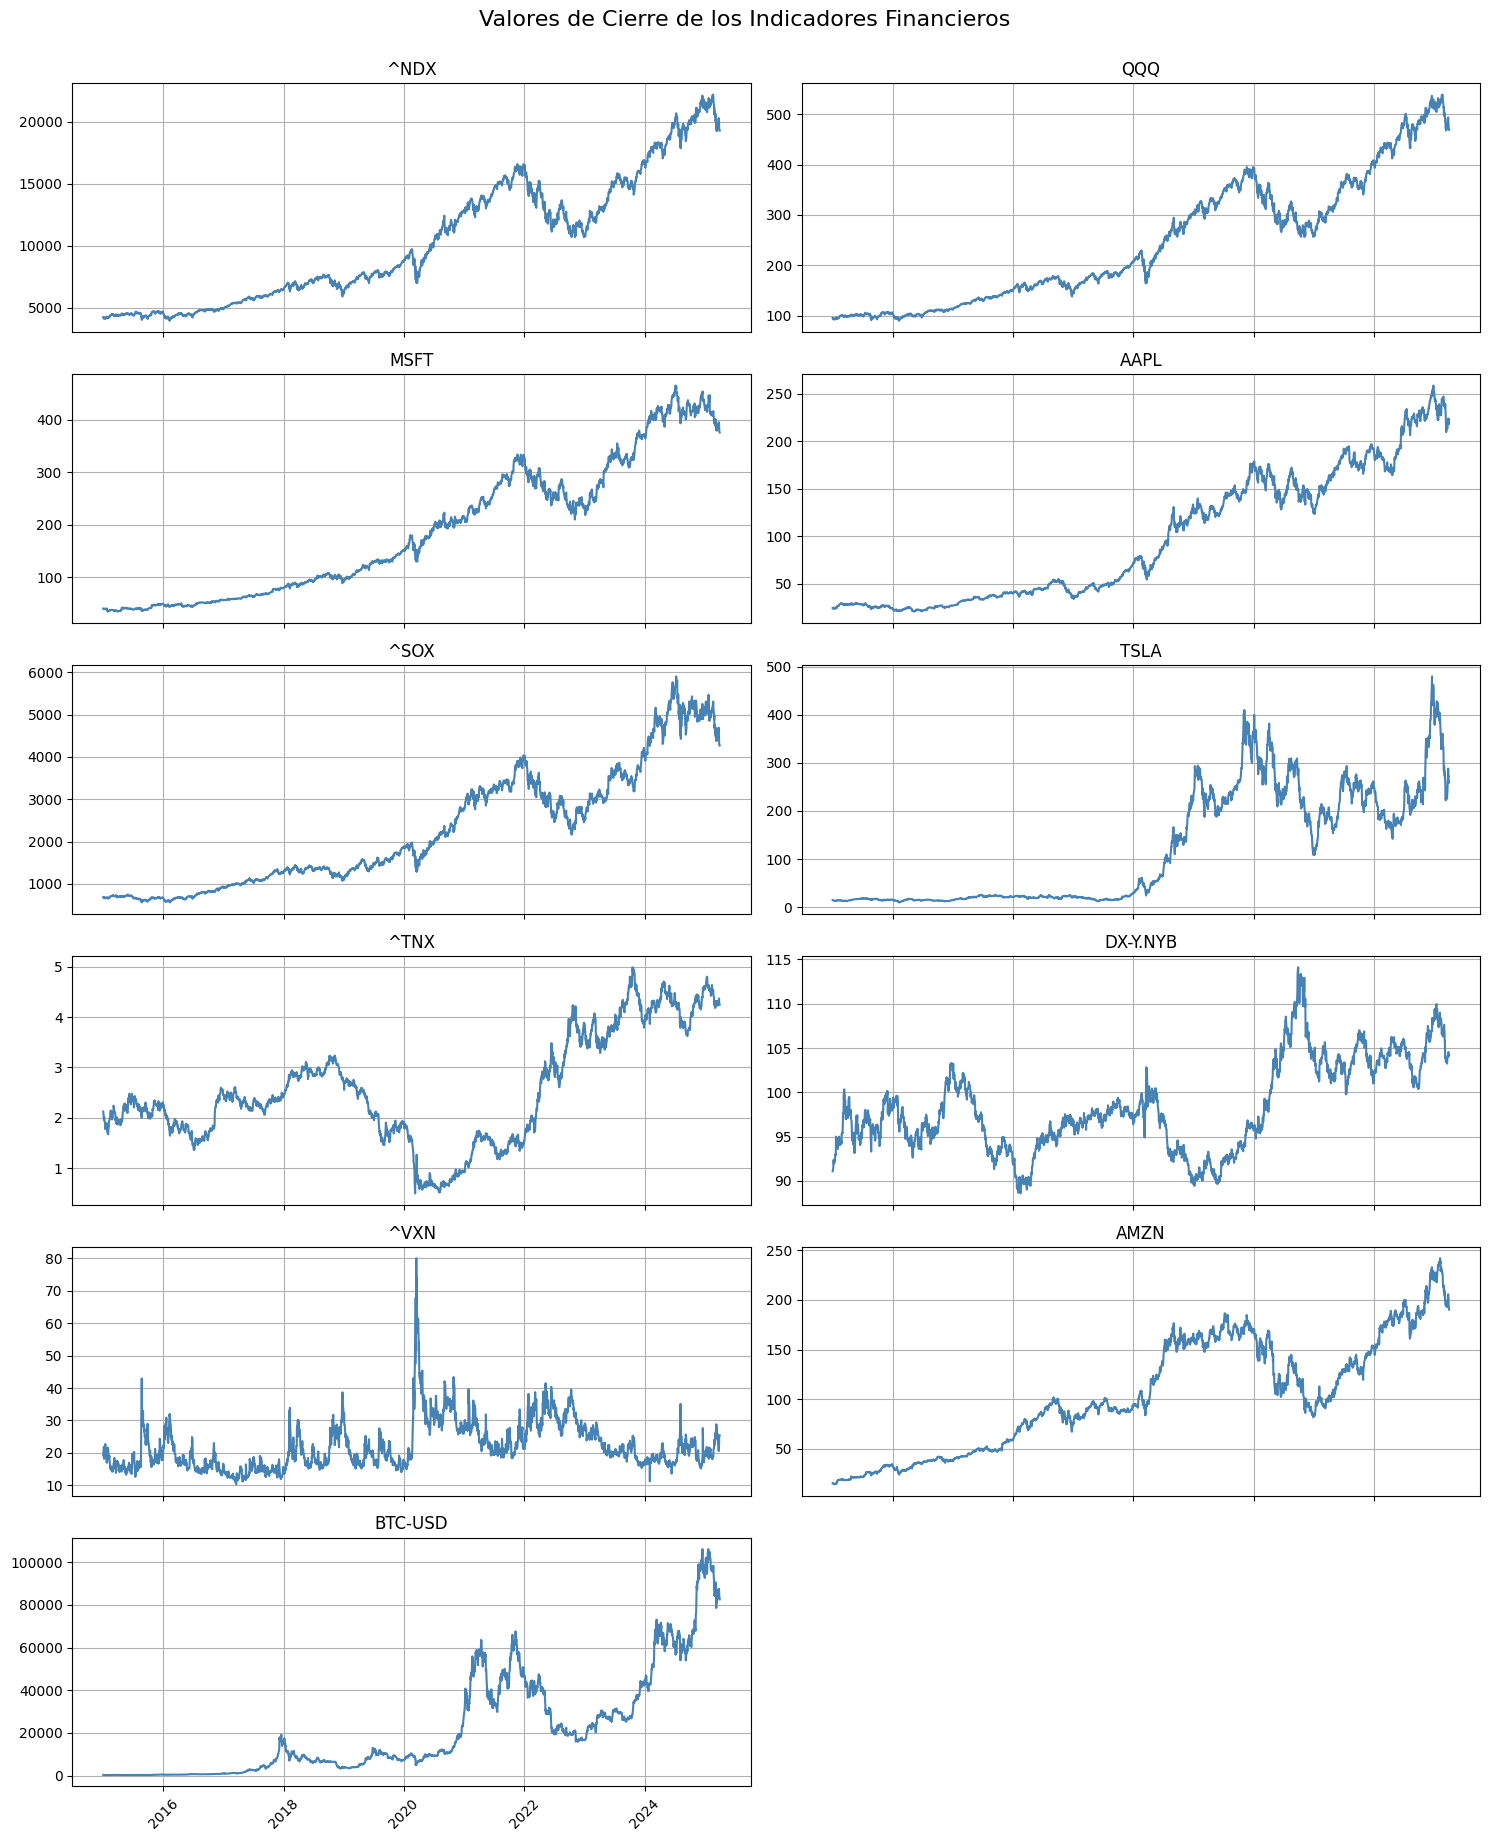

In [ ]:
# Número de variables a considerar #
cols = df_close.columns
n_vars = len(cols)

# Se crea la figura #
n_cols = 2
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows), sharex=True)
axes = axes.flatten()

# Se grafica cada serie #
for i, col in enumerate(cols):
    axes[i].plot(df_close.index, df_close[col], label=col, color='steelblue')
    axes[i].set_title(col)
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Valores de Cierre de los Indicadores Financieros', fontsize=16, y=1.02)
plt.show()

### 2.3. Distribución individual de cada activo

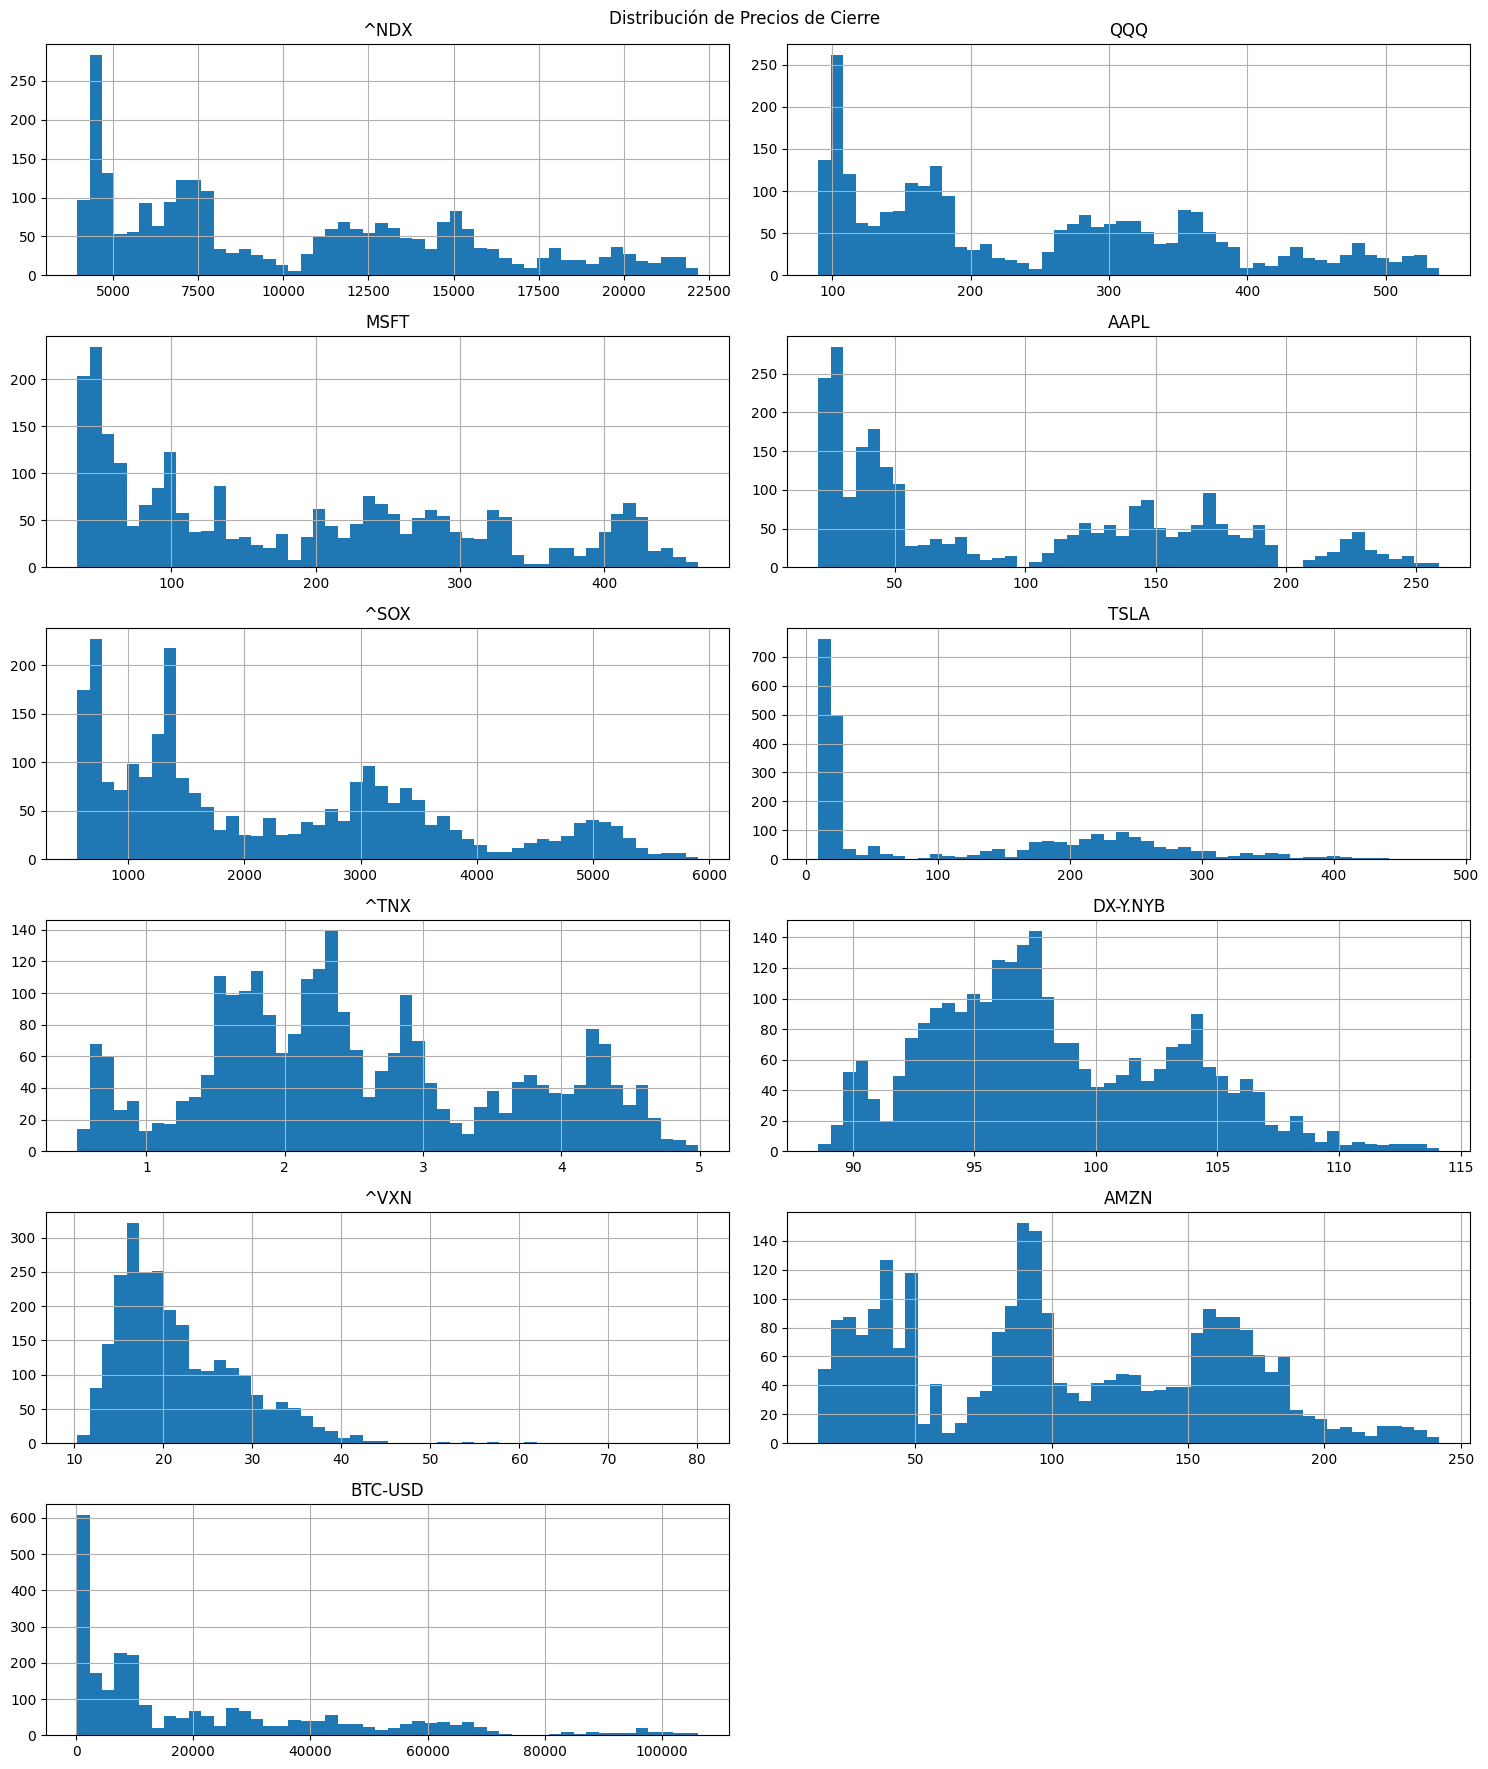

In [ ]:
# Se construyen histogramas por cada activo con el fin de observar la distribución de los datos #
df_close.hist(bins = 50, figsize = (15, 3 * n_rows), layout = (6, 2))
plt.suptitle("Distribución de Precios de Cierre")
plt.tight_layout()
plt.show()

#### 2.3.1. Análisis de Normalidad de las Variables

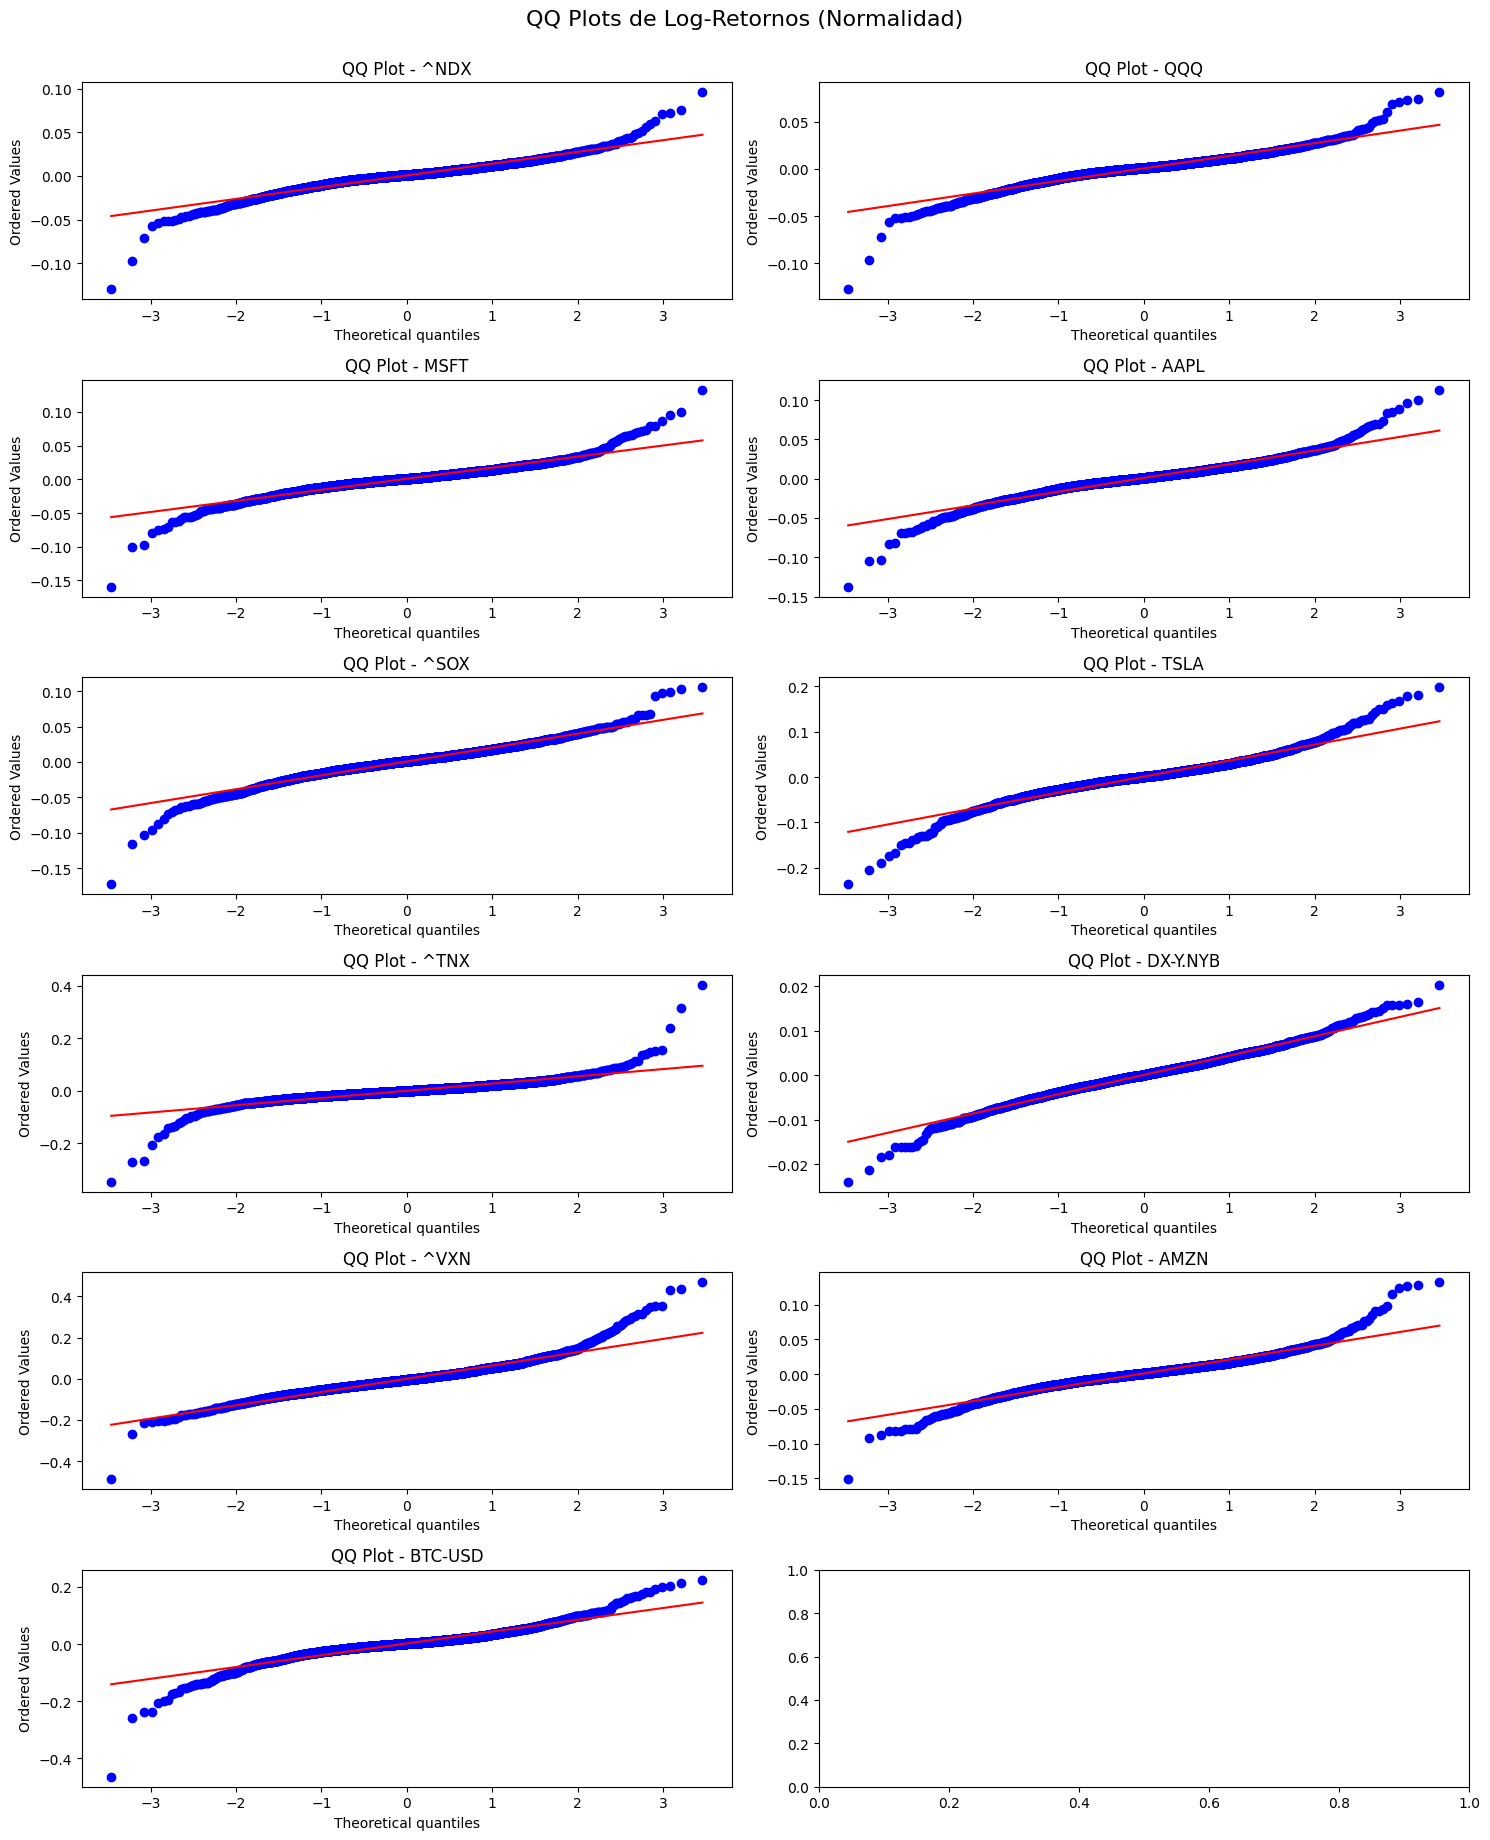

In [ ]:
# Cálculo de log-retornos #
log_returns = np.log(df_close / df_close.shift(1)).dropna()

# QQ Plot por variable #
cols = log_returns.columns
n_vars = len(cols)
n_cols = 2
n_rows = math.ceil(n_vars / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    stats.probplot(log_returns[col], dist="norm", plot=axes[i])
    axes[i].set_title(f"QQ Plot - {col}")

plt.tight_layout()
plt.suptitle("QQ Plots de Log-Retornos (Normalidad)", fontsize=16, y=1.02)
plt.show()

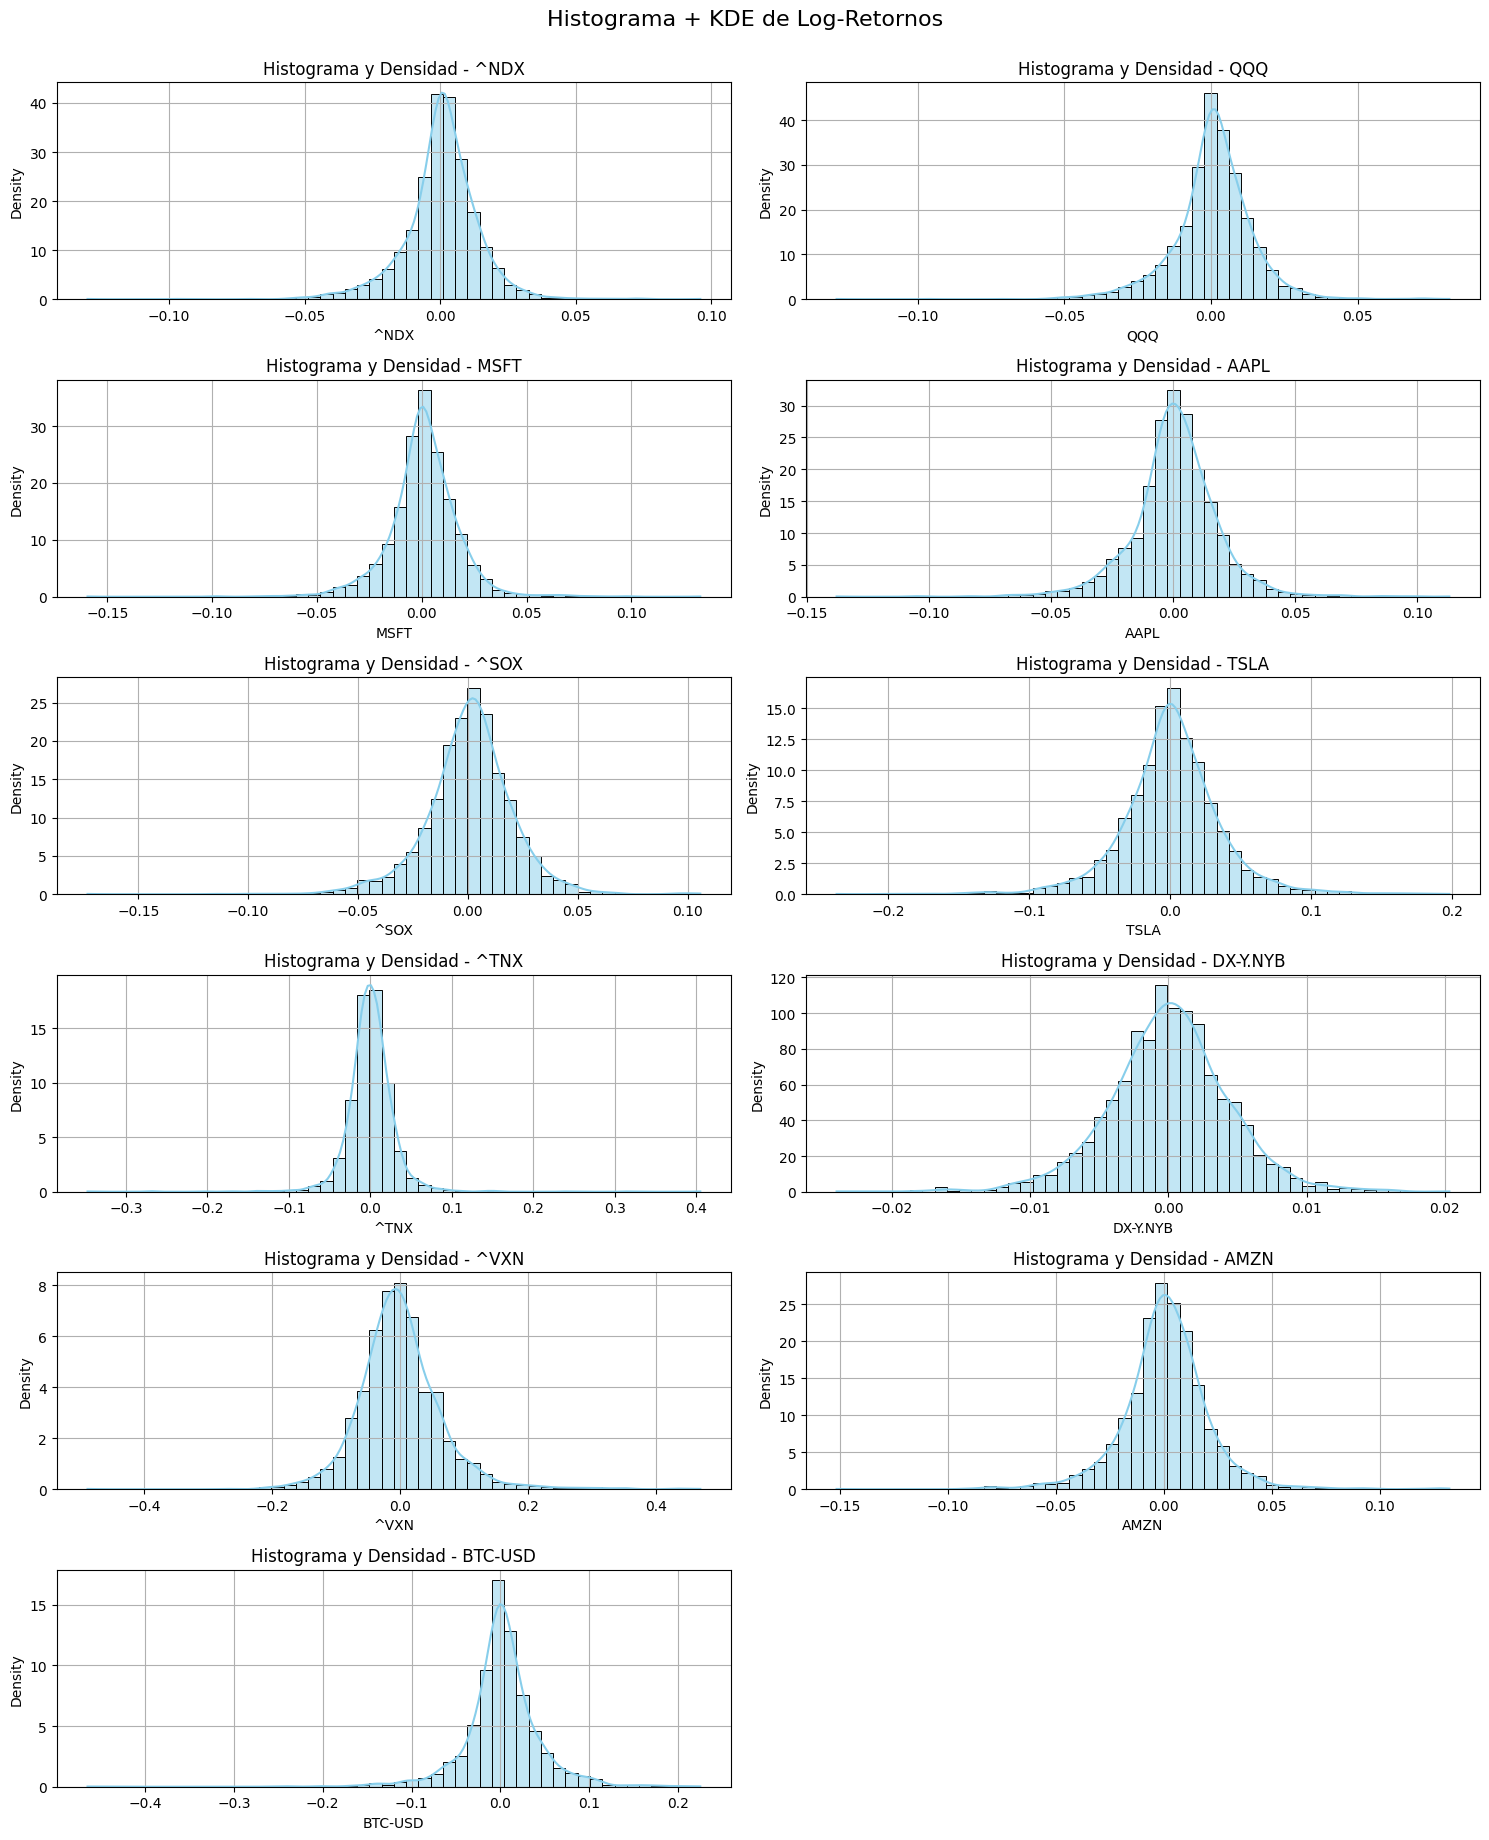

In [ ]:
# Histograma + Curva de densidad #

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(log_returns[col], kde=True, stat='density', ax=axes[i], color="skyblue", bins=50)
    axes[i].set_title(f"Histograma y Densidad - {col}")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Histograma + KDE de Log-Retornos", fontsize=16, y=1.02)
plt.show()

In [ ]:
# Se inicializa una lista para almacenar los resultados #
normality_results = []

# Se itera por cada serie #
for col in log_returns.columns:
    serie = log_returns[col].dropna()

    # Test de Shapiro-Wilk
    shapiro_stat, shapiro_p = shapiro(serie)

    # Test de Jarque-Bera
    jb_stat, jb_p = jarque_bera(serie)

    normality_results.append({
        'Variable': col,
        'Shapiro-Wilk Stat': round(shapiro_stat, 4),
        'Shapiro-Wilk p': round(shapiro_p, 8),
        'Jarque-Bera Stat': round(jb_stat, 4),
        'Jarque-Bera p': round(jb_p, 4)
    })

# Se convierten los resultados a DataFrame #
normality_df = pd.DataFrame(normality_results)

# Se muestra la tabla ordenada por Shapiro p-value (más bajo = más lejos de normal)
normality_df.sort_values(by='Shapiro-Wilk p', inplace=True)
print(normality_df)

    Variable  Shapiro-Wilk Stat  Shapiro-Wilk p  Jarque-Bera Stat  \
0       ^NDX             0.9336             0.0         5327.5503   
1        QQQ             0.9344             0.0         4873.8405   
2       MSFT             0.9265             0.0         6827.6021   
3       AAPL             0.9435             0.0         3038.7339   
4       ^SOX             0.9588             0.0         2472.7805   
5       TSLA             0.9478             0.0         1983.7472   
6       ^TNX             0.8168             0.0       105136.0489   
7   DX-Y.NYB             0.9854             0.0          315.6397   
8       ^VXN             0.9335             0.0         4075.6260   
9       AMZN             0.9366             0.0         3513.1209   
10   BTC-USD             0.9070             0.0         9399.0766   

    Jarque-Bera p  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0  
6             0.0  
7          

### 2.4. Matriz de correlación entre activos

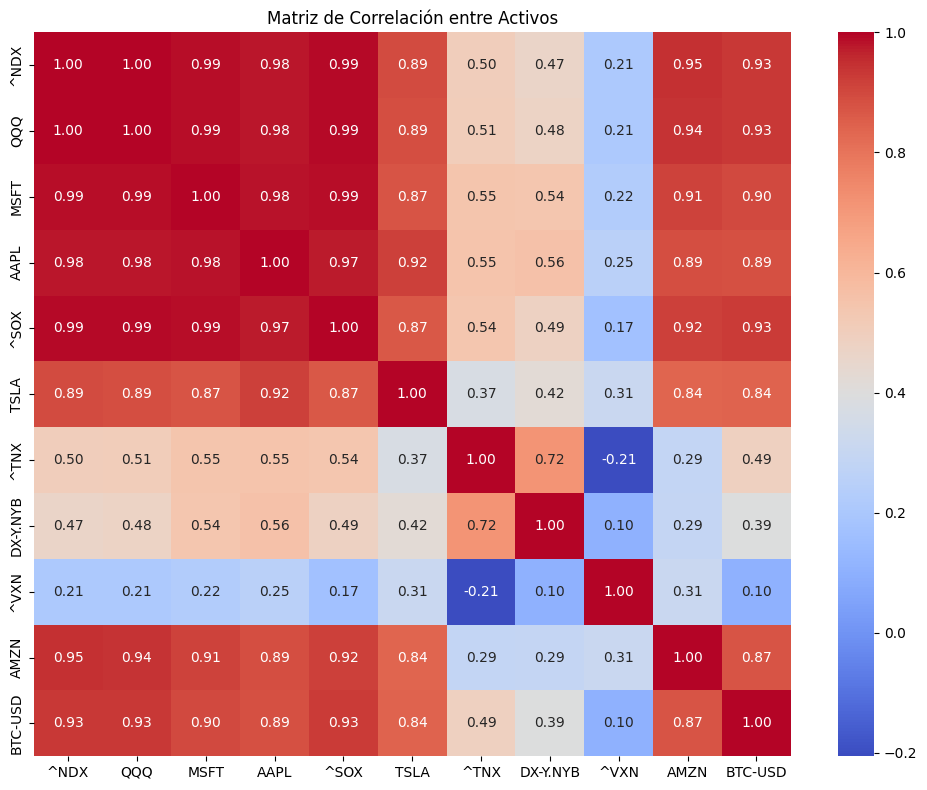

In [ ]:
# Se grafica la matriz mediante un Heatmap #
plt.figure(figsize = (10, 8))
sns.heatmap(df_close.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Matriz de Correlación entre Activos')
plt.tight_layout()
plt.show()

In [ ]:
df_close

^NDX         QQQ        MSFT        AAPL         ^SOX  \
Date                                                                        
2015-01-02   4230.240234   95.123276   40.072117   24.320431   686.729980   
2015-01-05   4160.959961   93.727928   39.703632   23.635286   673.590027   
2015-01-06   4110.830078   92.471207   39.120895   23.637508   658.830017   
2015-01-07   4160.000000   93.663269   39.617943   23.968954   665.270020   
2015-01-08   4240.549805   95.455963   40.783436   24.889902   684.650024   
...                  ...         ...         ...         ...          ...   
2025-03-25  20287.830078  493.459991  395.160004  223.750000  4661.339844   
2025-03-26  19916.990234  484.380005  389.970001  221.529999  4508.740234   
2025-03-27  19798.619141  481.619995  390.579987  223.850006  4415.250000   
2025-03-28  19281.400391  468.940002  378.799988  217.899994  4284.910156   
2025-03-31  19278.449219  468.920013  375.390015  222.130005  4270.430176   

                  TSLA   ^TNX    DX-Y.NYB       ^VXN        AMZN       BTC-USD  
Date                                                                            
2015-01-02   14.620667  2.123   91.080002  19.200001   15.426000    315.032013  
2015-01-05   14.006000  2.039   91.379997  20.719999   15.109500    274.473999  
2015-01-06   14.085333  1.963   91.500000  21.850000   14.764500    286.188995  
2015-01-07   14.063333  1.954   91.889999  20.160000   14.921000    294.337006  
2015-01-08   14.041333  2.016   92.370003  18.150000   15.023000    283.348999  
...                ...    ...         ...        ...         ...           ...  
2025-03-25  288.140015  4.307  104.180000  20.570000  205.710007  87471.703125  
2025-03-26  272.059998  4.338  104.550003  22.040001  201.130005  86900.882812  
2025-03-27  273.130005  4.369  104.070000  22.410000  201.360001  87177.101562  
2025-03-28  263.549988  4.255  104.040001  25.059999  192.720001  84353.148438  
2025-03-31  259.160004  4.246  104.209999  25.370001  190.259995  82548.914062  

[2576 rows x 11 columns]

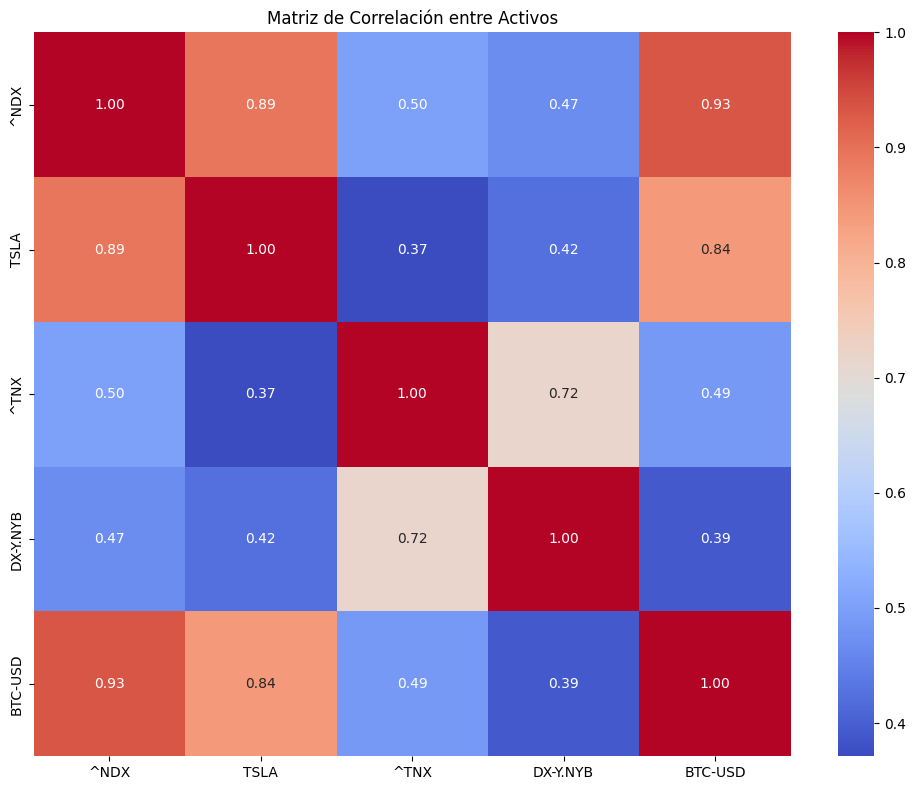

In [ ]:
# Nuevo DF sin las variables más correlacionadas #
var_a_eliminar = ['QQQ','MSFT','AAPL','^SOX','AMZN',"^VXN"]
df_close2 = df_close.drop(columns=var_a_eliminar)

# Se grafica la matriz mediante un Heatmap #
plt.figure(figsize = (10, 8))
sns.heatmap(df_close2.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Matriz de Correlación entre Activos')
plt.tight_layout()
plt.show()

### 2.5. Construcción de Boxplots para ver outliers

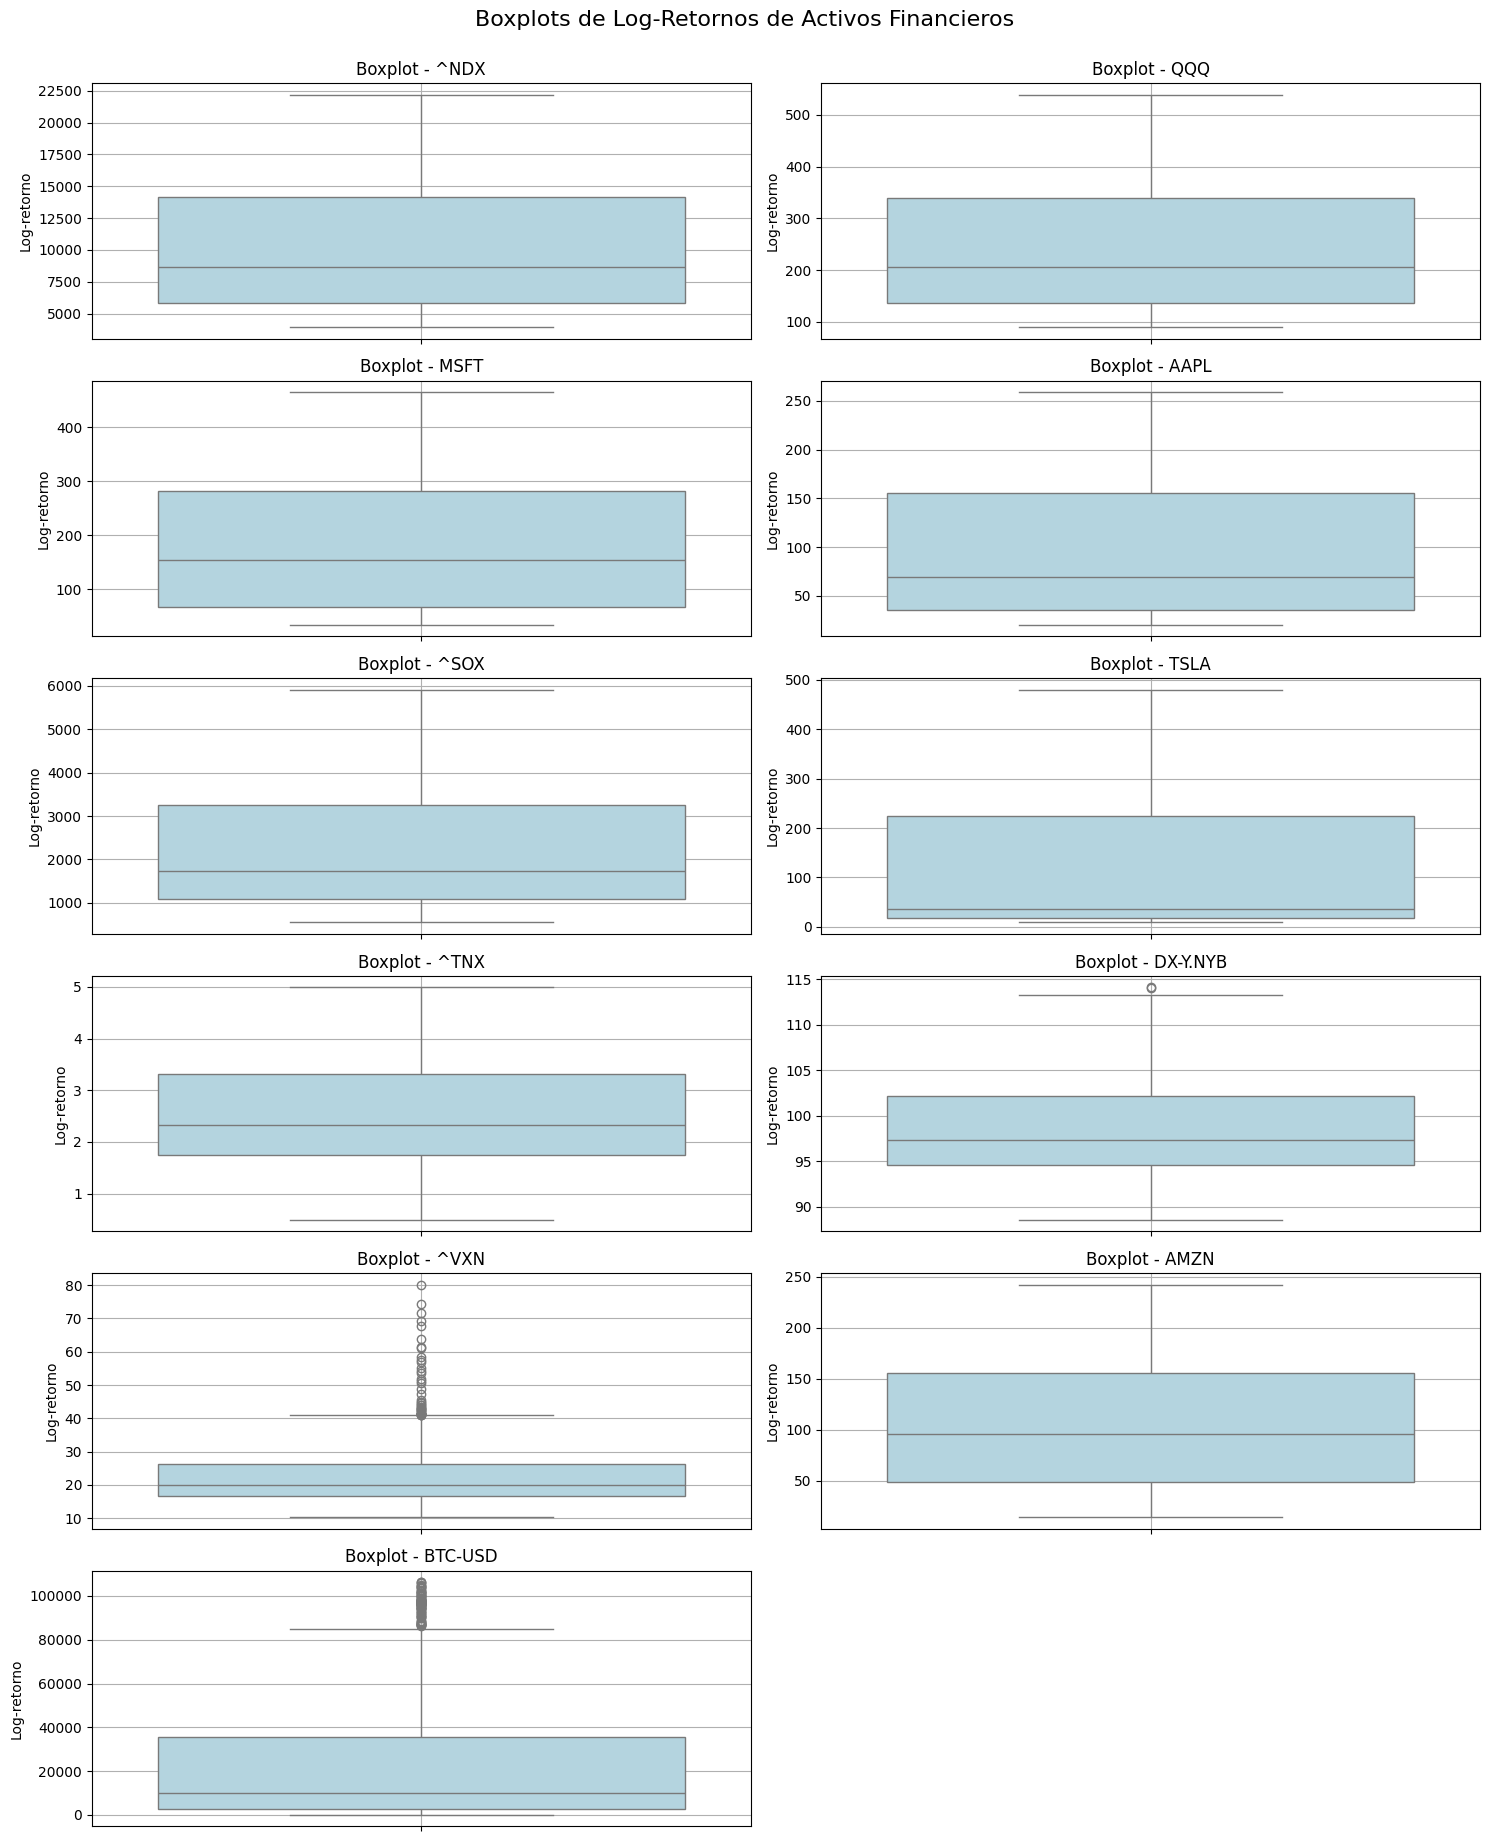

In [ ]:
# Boxplot por variable #
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(y=df_close[col], ax=axes[i], color="lightblue")
    axes[i].set_title(f"Boxplot - {col}")
    axes[i].set_ylabel('Log-retorno')
    axes[i].grid(True)

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout
plt.tight_layout()
plt.suptitle("Boxplots de Log-Retornos de Activos Financieros", fontsize=16, y=1.02)
plt.show()


### 2.6. Análisis de Componentes Principales (PCA)

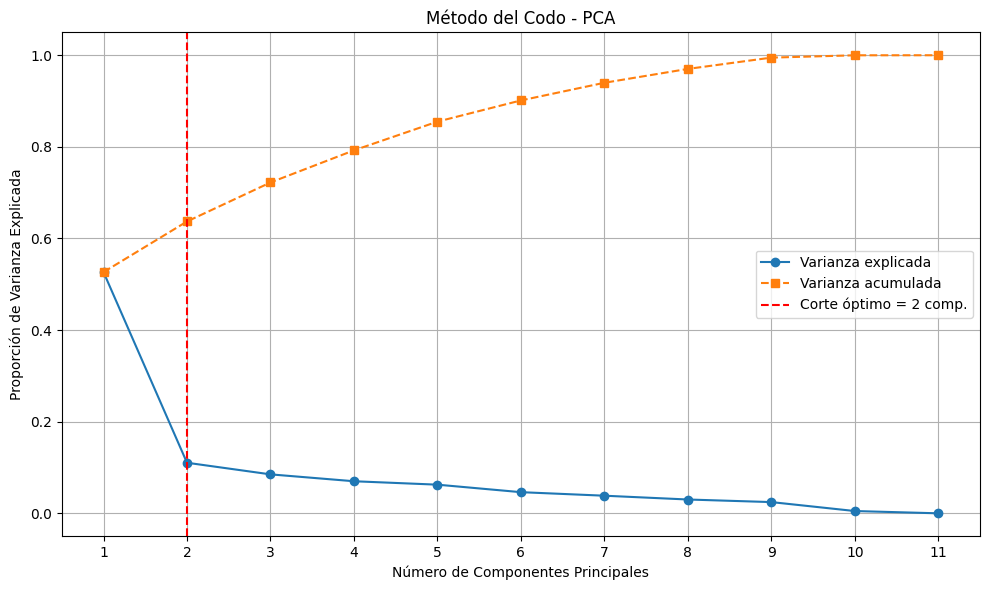

In [ ]:
# Se calculan los log-retornos #
log_returns = np.log(df_close / df_close.shift(1)).dropna()

# Se estandarizan los datos #
scaler = StandardScaler()
log_returns_scaled = scaler.fit_transform(log_returns)

# Se aplica el PCA #
pca = PCA()
pca.fit(log_returns_scaled)

# Varianza explicada por componente #
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Scree plot (gráfico del codo) #
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', label='Varianza explicada')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 's--', label='Varianza acumulada')

optimal_components = np.argmax(cumulative_var >= 0.60) + 1  # por ejemplo, 60% de varianza acumulada
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'Corte óptimo = {optimal_components} comp.')

plt.title('Método del Codo - PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.xticks(range(1, len(explained_var) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Se crea la tabla resumen de la varianza explicada de cada componente #
pca_table = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var))],
    'Varianza Explicada': explained_var.round(4),
    'Varianza Acumulada': cumulative_var.round(4)
})

print(pca_table)

   Componente  Varianza Explicada  Varianza Acumulada
0         PC1              0.5266              0.5266
1         PC2              0.1105              0.6371
2         PC3              0.0851              0.7223
3         PC4              0.0701              0.7924
4         PC5              0.0627              0.8550
5         PC6              0.0463              0.9013
6         PC7              0.0386              0.9399
7         PC8              0.0303              0.9702
8         PC9              0.0246              0.9948
9        PC10              0.0051              0.9999
10       PC11              0.0001              1.0000


In [ ]:
# Cargas principales de los activos #
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(explained_var))],
    index=log_returns.columns
)

# Se muestran solamente las primeras 5 componentes principales #
print("Cargas principales (loadings):")
print(loadings.iloc[:, :11].round(4))  # ajusta si deseas ver más o menos componentes

Cargas principales (loadings):
             PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8  \
^NDX     -0.4097 -0.0081  0.0434  0.0159  0.0445  0.0277  0.0639 -0.1182   
QQQ      -0.4095 -0.0045  0.0436  0.0095  0.0461  0.0312  0.0589 -0.1108   
MSFT     -0.3604  0.0263  0.0756  0.0701  0.1977  0.1529  0.0812 -0.1376   
AAPL     -0.3419  0.0261  0.0707 -0.0194  0.0818 -0.0103  0.6591  0.5791   
^SOX     -0.3613 -0.0054  0.0002 -0.0770  0.0080 -0.2278  0.1273 -0.6809   
TSLA     -0.2493 -0.0869 -0.0788  0.0548 -0.9448  0.0218 -0.0584  0.0813   
^TNX     -0.0913  0.6542 -0.2564 -0.6691 -0.0380  0.1942 -0.0962  0.0407   
DX-Y.NYB  0.0380  0.7128 -0.0598  0.6872 -0.0468 -0.0612  0.0588 -0.0538   
^VXN      0.3161 -0.0720 -0.0812  0.0286 -0.1240  0.6924  0.5189 -0.3399   
AMZN     -0.3199 -0.0650  0.1095  0.1980  0.1326  0.6332 -0.4996  0.1616   
BTC-USD  -0.1134 -0.2134 -0.9441  0.1594  0.1444 -0.0227 -0.0138  0.0552   

             PC9    PC10    PC11  
^NDX      0.0221 -0.5

Según los resultados, en donde se observa por el método del codo, un corte dentro de la segunda componente, el cual representa aproximadamente el 64% de la varianza explicada, se tiene que esta componente tiene pesos positivos fuertes en: el 'DX-Y.NYB' (Dólar) con +0.7863, y '^TNX' (Tasa del Tesoro 10 años) con el +0.6135, mencionando que este componente representa un factor macroeconómico relacionado con dólar fuerte y tasas altas, posiblemente ligado a expectativas de inflación o política monetaria.

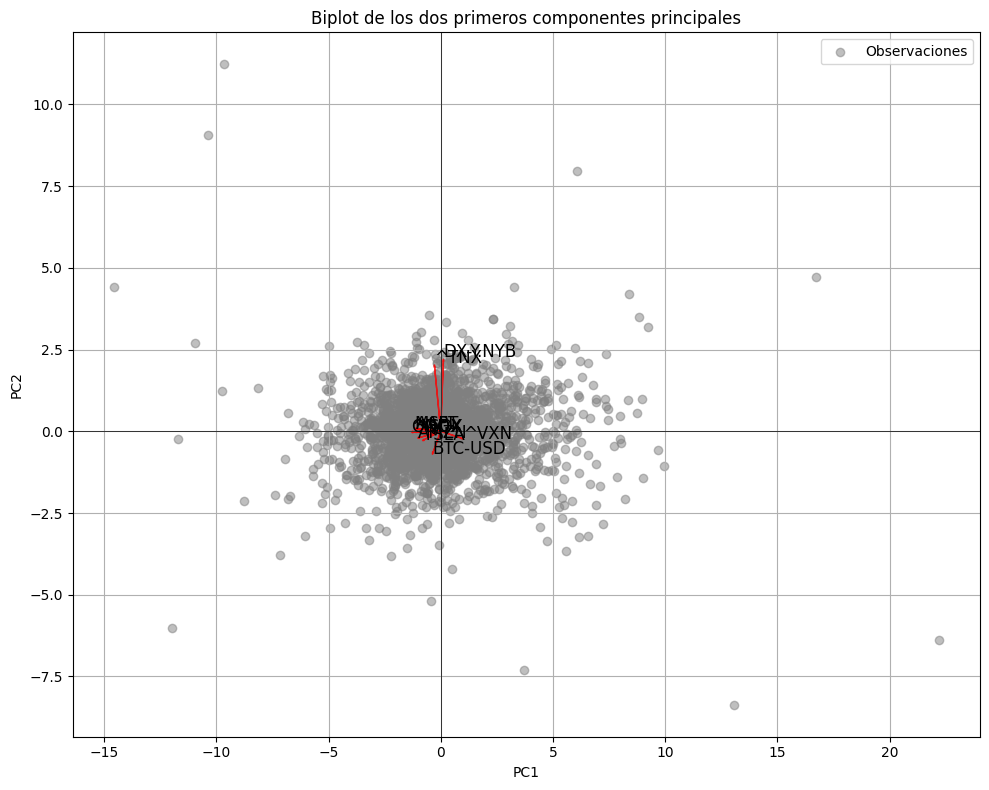

In [ ]:
# Proyección de los datos en los dos primeros componentes
pca_2d = PCA(n_components=2)
proj = pca_2d.fit_transform(log_returns_scaled)

# Crear figura
plt.figure(figsize=(10, 8))
plt.scatter(proj[:, 0], proj[:, 1], alpha=0.5, color='grey', label='Observaciones')

# Añadir vectores (cargas)
for i, var in enumerate(log_returns.columns):
    plt.arrow(0, 0,
              pca_2d.components_[0, i] * 3,  # escala para visualización
              pca_2d.components_[1, i] * 3,
              color='red', alpha=0.8, head_width=0.05)
    plt.text(pca_2d.components_[0, i] * 3.2,
             pca_2d.components_[1, i] * 3.2,
             var, fontsize=12)

plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Biplot de los dos primeros componentes principales")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Se hará ahora un PCA sin las variables más correlacionadas según la matriz de correlación

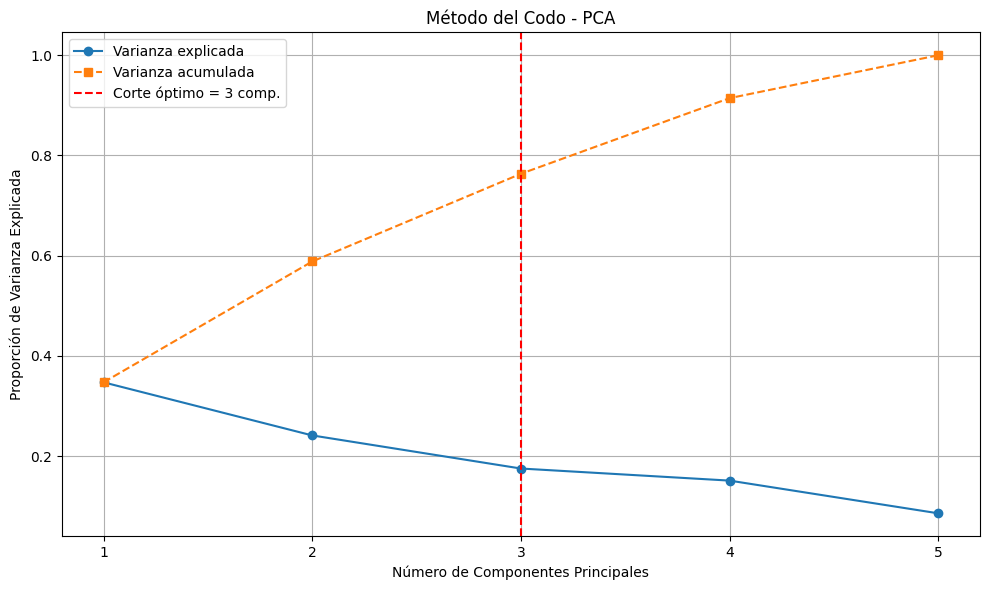

In [ ]:
# Se calculan los log-retornos #
log_returns = np.log(df_close2 / df_close2.shift(1)).dropna()

# Se estandarizan los datos #
scaler = StandardScaler()
log_returns_scaled = scaler.fit_transform(log_returns)

# Se aplica el PCA #
pca = PCA()
pca.fit(log_returns_scaled)

# Varianza explicada por componente #
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Scree plot (gráfico del codo) #
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', label='Varianza explicada')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 's--', label='Varianza acumulada')

optimal_components = np.argmax(cumulative_var >= 0.60) + 1  # por ejemplo, 60% de varianza acumulada
plt.axvline(x=optimal_components, color='red', linestyle='--', label=f'Corte óptimo = {optimal_components} comp.')

plt.title('Método del Codo - PCA')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.xticks(range(1, len(explained_var) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Se crea la tabla resumen de la varianza explicada de cada componente #
pca_table = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var))],
    'Varianza Explicada': explained_var.round(4),
    'Varianza Acumulada': cumulative_var.round(4)
})

print(pca_table)

  Componente  Varianza Explicada  Varianza Acumulada
0        PC1              0.3472              0.3472
1        PC2              0.2412              0.5883
2        PC3              0.1751              0.7634
3        PC4              0.1510              0.9143
4        PC5              0.0857              1.0000


In [ ]:
# Cargas principales de los activos #
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(explained_var))],
    index=log_returns.columns
)

# Se muestran solamente las primeras 5 componentes principales #
print("Cargas principales (loadings):")
print(loadings.iloc[:, :11].round(4))  # ajusta si deseas ver más o menos componentes

Cargas principales (loadings):
             PC1     PC2     PC3     PC4     PC5
^NDX     -0.6510  0.0283  0.1918  0.0415  0.7328
TSLA     -0.6126 -0.0337  0.3363  0.3009 -0.6480
^TNX     -0.2201  0.6771 -0.0519 -0.6794 -0.1696
DX-Y.NYB  0.1182  0.7153 -0.1549  0.6663  0.0802
BTC-USD  -0.3722 -0.1673 -0.9074  0.0454 -0.0893


## 3. Descomposición de la serie temporal del Nasdaq-100

La descomposición de la serie ayudará a separar tendencia, estacionalidad y ruido, con el fin de evaluar si hay patrones estacionales o si la serie tiene un comportamiento más irregular y justificar si se debe aplicar modelos como SARIMA o si basta con un ARIMA simple.

In [ ]:
# Indice NDX a Serie de tiempo #
ndx_series = df_close2['^NDX'].copy()
ndx_series.index = pd.to_datetime(ndx_series.index)
# Se establece la frecuencia diaria de día hábil #
ndx_series = ndx_series.asfreq('B')

Se procede a hacer la descomposición con log-retornos o retornos simples, en donde el análisis se hace sobre los cambios relativos (%) y no sobre el nivel de precios. Se hace sobre los log-retornos, ya que suelen ser más estacionarios , lo cual es una propiedad importante en modelos estadísticos y que con esto, se pueden detectar patrones de volatilidad o cambios estructurales de una manera más fácil.

Dado que se está trabajando con modelos predictivos para el ^NDX, y que luego se usarán técnicas como modelos estadísticos o de ML, lo recomendable es trabajar con los log-retornos, garantizando mayor estacionariedad, un mejor comportamiento estadístico y una mayor comparabilidad entre activos.

<Figure size 1500x900 with 0 Axes>

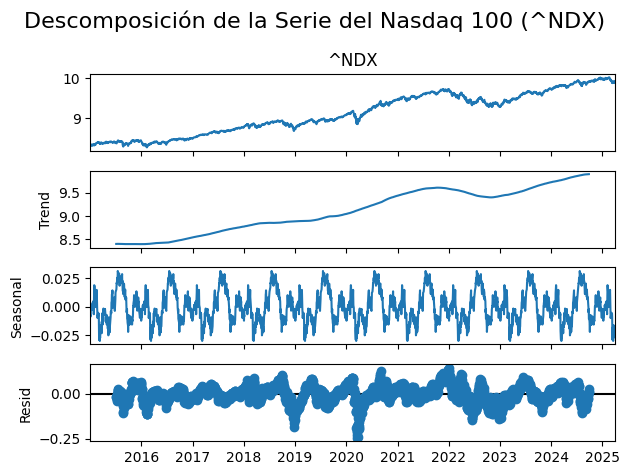

In [ ]:
# Se calcula los log-retornos #
log_ndx = np.log(ndx_series)
log_ndx = log_ndx.dropna()

# Se hace la descomposición de la serie estableciendo un periodo de 252 hábiles #
decomp = seasonal_decompose(log_ndx, model='additive', period=252)

# Se visualiza la descomposición #
plt.figure(figsize=(15, 9))
decomp.plot()
plt.suptitle('Descomposición de la Serie del Nasdaq 100 (^NDX)', fontsize=16)
plt.tight_layout()
plt.show()

La descomposición de la serie logarítmica del índice del Nasdaq-100 reveló una estructura compuesta por una tendencia de crecimiento sostenido, una estacionalidad cíclica de baja magnitud, y residuos que capturan choques externos o eventos macroeconómicos puntuales. Esta estructura respalda la elección de modelos que consideren tanto componentes deterministas (como modelo SARIMA) y como no lineales (como redes neuronales o XGBoost), permitiendo una predicción más robusta de la dinámica del mercado tecnológico.

## 4. Modelado Predictivo

### 4.1. Modelos Clásicos

#### 4.1.1. Revisión de estacionariedad de la serie temporal para modelos clásicos

Con el fin de observar si una serie es estacionaria (requisito clave para ciertos modelos de series de tiempo como ARIMA o SARIMA), se puede usar el Dickey-Fuller test para verificar estacionaridad y aplicar diferenciación si es necesario.

In [ ]:
# Lista de variables a analizar
variables = [ "^NDX", "TSLA", "^TNX", "DX-Y.NYB", "BTC-USD"]

# Asumiendo que 'df' es tu DataFrame con estas columnas #
results = {}

for var in variables:
    adf_test = adfuller(df_close2[var].dropna())  # Eliminamos valores nulos antes de aplicar el test
    results[var] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Se muestran los resultados #
for var, result in results.items():
    print(f"{var}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")

^NDX: ADF Statistic = 0.09531811648051698, p-value = 0.9657399826319388
TSLA: ADF Statistic = -1.4709623639873695, p-value = 0.5478238378779059
^TNX: ADF Statistic = -0.7057934760055582, p-value = 0.8452431843641265
DX-Y.NYB: ADF Statistic = -2.0812972909397374, p-value = 0.2521012473280408
BTC-USD: ADF Statistic = -0.6461934499782123, p-value = 0.8601989402550227


Allí se observa que p-value de todos los activos, es mayor al 5%, lo que indica que ningún activo seleccionado es estacionaria y deberíamos aplicar diferenciación (diff()). De esta manera, se realizará la diferenciación de todo el DataFrame para la construcción de los modelos clásicos.

In [ ]:
# Diccionario con resultados del test ADF previamente calculados #
adf_results = {
    "^NDX": 0.9657399826319388, "TSLA": 0.5478238378779059, "^TNX": 0.8452431843641265,
    "DX-Y.NYB": 0.2521012473280408, "BTC-USD": 0.8601989402550227
}

# Lista de variables no estacionarias (p-value > 0.05) #
variables_no_estacionarias = [var for var, p_value in adf_results.items() if p_value > 0.05]
# Lista de variables estacionarias #
variables_estacionarias = [var for var in adf_results if var not in variables_no_estacionarias]

# Se crea un nuevo DataFrame que contenga las variables diferenciadas y las originales que ya son estacionarias #
df_diff = pd.DataFrame()

# Aplicar diferenciación en las variables necesarias #
for var in variables_no_estacionarias:
    df_diff[f"{var}"] = df_close2[var].diff().dropna()
    print(f"Diferenciación aplicada a {var} (p-value = {adf_results[var]})")

# Incluir las variables que ya son estacionarias sin modificar #
for var in variables_estacionarias:
    df_diff[var] = df_close2[var]
    print(f"{var} es estacionaria y se mantiene sin cambios (p-value = {adf_results[var]})")

# Mostrar las primeras filas para verificar la transformación
print(df_diff.head())

Diferenciación aplicada a ^NDX (p-value = 0.9657399826319388)
Diferenciación aplicada a TSLA (p-value = 0.5478238378779059)
Diferenciación aplicada a ^TNX (p-value = 0.8452431843641265)
Diferenciación aplicada a DX-Y.NYB (p-value = 0.2521012473280408)
Diferenciación aplicada a BTC-USD (p-value = 0.8601989402550227)
                 ^NDX      TSLA   ^TNX  DX-Y.NYB    BTC-USD
Date                                                       
2015-01-05 -69.280273 -0.614668 -0.084  0.299995 -40.558014
2015-01-06 -50.129883  0.079333 -0.076  0.120003  11.714996
2015-01-07  49.169922 -0.022000 -0.009  0.389999   8.148010
2015-01-08  80.549805 -0.021999  0.062  0.480003 -10.988007
2015-01-09 -27.270020 -0.264000 -0.045 -0.430000   7.058990


In [ ]:
# Lista de variables a analizar
variables2 = [ "^NDX", "TSLA", "^TNX", "DX-Y.NYB", "BTC-USD"]

# Asumiendo que 'df' es tu DataFrame con estas columnas #
results2 = {}

for var in variables2:
    adf_test = adfuller(df_diff[var].dropna())  # Eliminamos valores nulos antes de aplicar el test
    results2[var] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Se muestran los resultados #
for var, result in results2.items():
    print(f"{var}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")

^NDX: ADF Statistic = -10.749647368276632, p-value = 2.685699936411634e-19
TSLA: ADF Statistic = -9.27061797617332, p-value = 1.3299164677021967e-15
^TNX: ADF Statistic = -38.04367038449006, p-value = 0.0
DX-Y.NYB: ADF Statistic = -22.15414516171127, p-value = 0.0
BTC-USD: ADF Statistic = -8.53243608970246, p-value = 1.029031387166846e-13


Luego de hacer nuevamene el test, se confirma que ya las series de activos seleccionadas son estacionarias y se puede seguir con el modelo ARIMA.

#### 4.1.2. Modelo ARIMA

Este modelo es clave para capturar patrones en series temporales, como tendencias y autocorrelaciones. En primer lugar, se seleccionan los parámetros (p, d, q). Para determinar estos valores adecuados de p, d y q, se sigue esta lógica:

- d (Diferenciación): Como ya se hizo una diferenciación en las series que no eran estacionarias., se usa d = 1.

- p y q (Orden autorregresivo y media móvil): Para los valores p y q se usan los gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF) para estimar estos parámetros.

In [ ]:
# Se define la serie diferenciada como objetivo #
serie_ndx = df_diff["^NDX"].dropna()

# División de los datos #
train_size = int(len(serie_ndx) * 0.8)
ndx_train, ndx_test = serie_ndx[:train_size], serie_ndx[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(ndx_train)}")
print(f"Tamaño del conjunto de prueba: {len(ndx_test)}")

Tamaño del conjunto de entrenamiento: 2060
Tamaño del conjunto de prueba: 515


#### * Autocorrelación (ACF) y Autocorrelación Parcial (PACF) *

Ambos son fundamentales para poder identificar el orden del modelo ARIMA, en donde el ACF sugiere el orden de la parte MA (o valor q), mientras que el PACF indica el orden de la parte AR (o valor p). Por otro lado, estos son fundamentales para ver si la serie tiene memoria temporal, es decir, si los valores pasados ayudan a predecir el futuro.

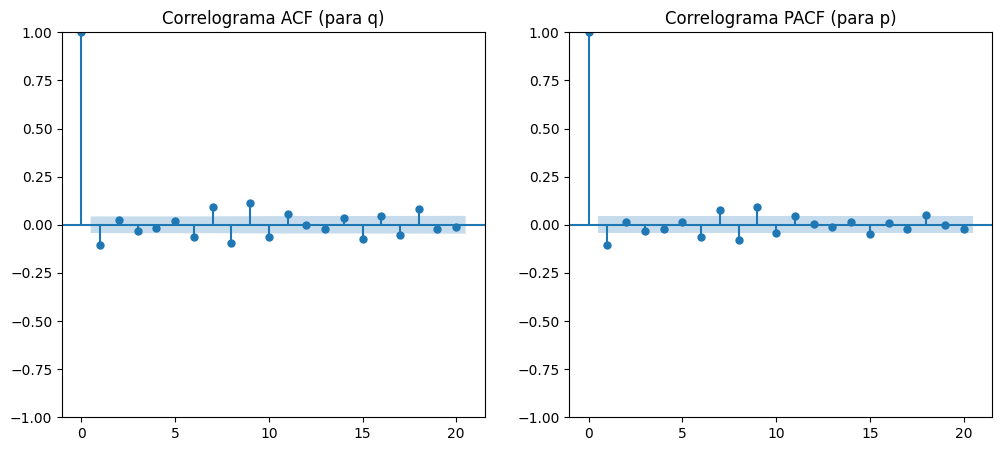

In [ ]:
# Graficos ACF y PACF #
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(ndx_train, ax=ax[0], lags=20)  # Correlograma ACF (q)
sm.graphics.tsa.plot_pacf(ndx_train, ax=ax[1], lags=20)  # Correlograma PACF (p)
ax[0].set_title("Correlograma ACF (para q)")
ax[1].set_title("Correlograma PACF (para p)")
plt.show()

Según estos gráficos ACF y PACF, se observa que en el ACF, el primer rezago tiene autocorrelación significativa, mientras que los siguientes rezagos están dentro del intervalo de confianza, lo que sugiere que q = 1 puede ser una buena elección.

Por otro lado, en el PACF se observa que el primer rezago es significativo y los demás caen dentro del intervalo de confianza, lo que sugiere que p = 1 es adecuado.

Por esto, los valores recomendados para el modelo ARIMA serían p = 1, d = 1, q = 1.

In [ ]:
# Se definen los parámetros según ACF y PACF anterior #
p, d, q = 1,1,1

# Se entrena el modelo ARIMA con los datos de entrenamiento #
modelo_arima = ARIMA(ndx_train, order=(p, d, q))
resultado_arima = modelo_arima.fit()

# Se muestra el resumen del modelo #
print(resultado_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   ^NDX   No. Observations:                 2060
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13120.710
Date:                Wed, 30 Apr 2025   AIC                          26247.419
Time:                        13:17:43   BIC                          26264.309
Sample:                             0   HQIC                         26253.612
                               - 2060                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1034      0.013     -8.237      0.000      -0.128      -0.079
ma.L1         -0.9997      0.004   -238.227      0.000      -1.008      -0.991
sigma2      1.997e+04    360.600     55.383      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


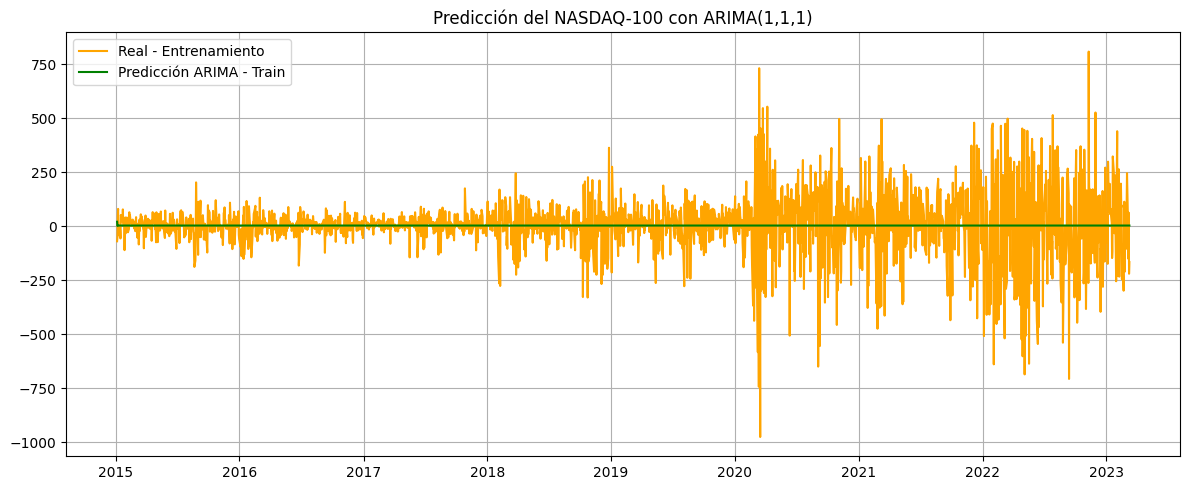

In [ ]:
# Se realizan las predicciones en el conjunto de entrenamiento #
pred_arima_train = resultado_arima.forecast(steps=len(ndx_train))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_train, label='Real - Entrenamiento', color='orange')
plt.plot(ndx_train.index, pred_arima_train, label='Predicción ARIMA - Train', color='green')
plt.title('Predicción del NASDAQ-100 con ARIMA(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


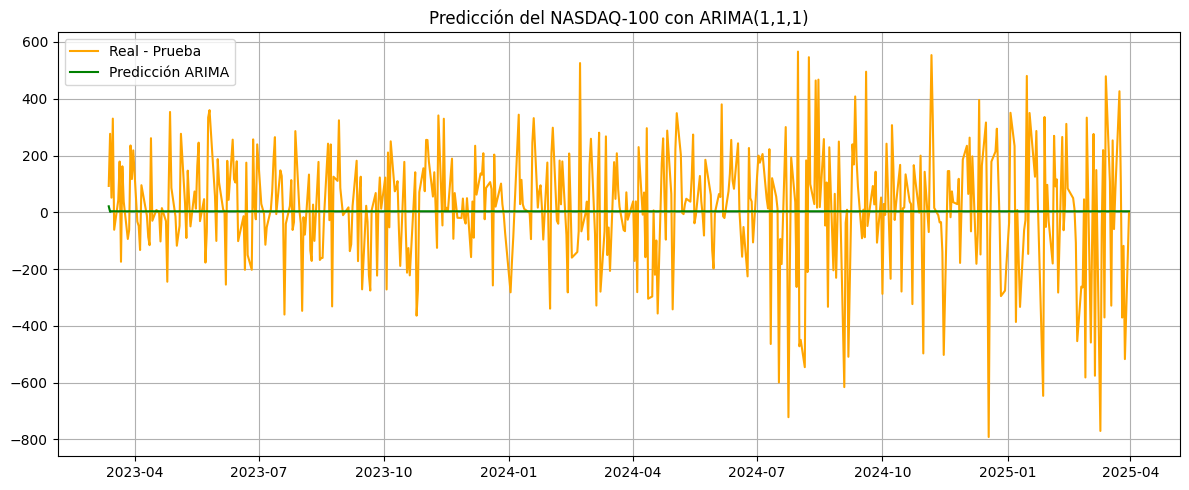

In [ ]:
# Se realizan las predicciones en el conjunto de prueba #
pred_arima = resultado_arima.forecast(steps=len(ndx_test))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, pred_arima, label='Predicción ARIMA', color='green')
plt.title('Predicción del NASDAQ-100 con ARIMA(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ahora, se calcularán las principales métricas de evaluación para el modelo ARIMA ajustado sobre la serie del Nasdaq. Estas son el RMSE (Root Mean Squared Error), el MAE (Mean Absolute Error), el R^2 (Coeficiente de determinación) y el AIC y BIC (de la parte entrenada del modelo).

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo ARIMA(1,1,1) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(ndx_test, pred_arima))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(ndx_test, pred_arima)
print(f"MAE: {mae:.4f}")

# R^2 - Entrenamiento #
r2_train = r2_score(ndx_train, pred_arima_train)
print(f"R^2 - Train: {r2_train:.4f}")

# R^2 - Test #
r2_test = r2_score(ndx_test, pred_arima)
print(f"R^2 - Test: {r2_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_arima.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_arima.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_ARIMA = {
    "modelo": "ARIMA(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2_train": r2_train,
    "r2_test": r2_test,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo ARIMA(1,1,1) - Serie NDX Diferenciada:
RMSE: 206.9926
MAE: 154.0305
R^2 - Train: -0.0001
R^2 - Test: -0.0027
AIC:  26247.42
BIC:  26264.31


Estos resultados sugieren que el modelo ARIMA no está capturando correctamente la dinámica de la serie temporal diferenciada al tener RMSE alto (208.92) y un MAE alto (157.90). Estos valores indican que el modelo está cometiendo errores significativos al predecir los valores futuros, ya que un buen modelo debería tener RMSE y MAE bajos, lo que significaría que las predicciones están más cerca de los valores reales.

Adicionalmente, se tiene un valor de R^2 negativo tanto para el conjunto de entrenamiento (-0.0001), como para el conjunto de prueba (-0.0027), lo que significa que el modelo es peor que simplemente tomar el promedio de la serie de prueba, y no está explicando la variabilidad de los datos, lo cual podría estar generando predicciones demasiado planas o poco informativas.

Por otro lado, según el gráfico, las predicciones no reflejan la volatilidad real del índice, lo que indica que el modelo podría estar demasiado restringido o no estar considerando cambios bruscos en la serie.

Es por ello que se procede con el ajuste de un modelo ARIMAX con las variables exógenas.

#### 4.1.3. Modelo ARIMAX

Se hace un modelado con ARIMAX, que es básicamente un ARIMA que incluye variables exógenas, en este caso otros activos o indicadores financieros, con el fin de mejorar la predicción del índice ^NDX.

In [ ]:
# Se define la variable objetivo y las exógenas #
y = df_diff["^NDX"].dropna()  # Variable dependiente
X = df_diff.drop(columns=["^NDX"]).dropna()  # Variables exógenas

# División de conjuntos (80% entrenamiento, 20% prueba) #
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

Del ACF y PACF se encontró que los mejores valores para p y q son 1, además de que el valor de d es igual a 1 también por la diferenciación hecha. De esta manera, se utilizan estos mismos valores

In [ ]:
# Se definen los parámetros óptimos #
p, d, q = 1, 1, 1

# Se ajusta el modelo ARIMAX con variables exógenas #
modelo_arimax = ARIMA(y_train, order=(p, d, q), exog = X_train)
resultado_arimax = modelo_arimax.fit()

# Resumen del modelo #
print(resultado_arimax.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   ^NDX   No. Observations:                 2060
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -12646.815
Date:                Wed, 30 Apr 2025   AIC                          25307.630
Time:                        13:27:44   BIC                          25347.040
Sample:                             0   HQIC                         25322.079
                               - 2060                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TSLA          13.4301      0.239     56.171      0.000      12.961      13.899
^TNX         302.8126     34.767      8.710      0.000     234.670     370.956
DX-Y.NYB     -35.0677      4.746     -7.389      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


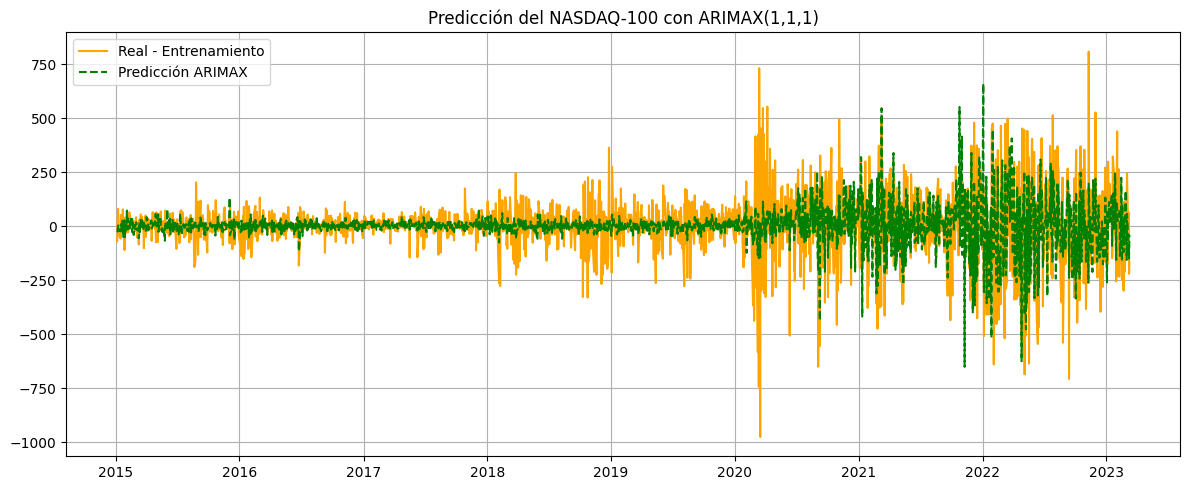

In [ ]:
# Se realizan las predicciones en el conjunto de entrenamiento #
pred_arimax_train = resultado_arimax.forecast(steps=len(y_train), exog=X_train)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(y_train, label='Entrenamiento')
plt.plot(y_train, label='Real - Entrenamiento', color='orange')
plt.plot(y_train.index, pred_arimax_train, label='Predicción ARIMAX', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con ARIMAX(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


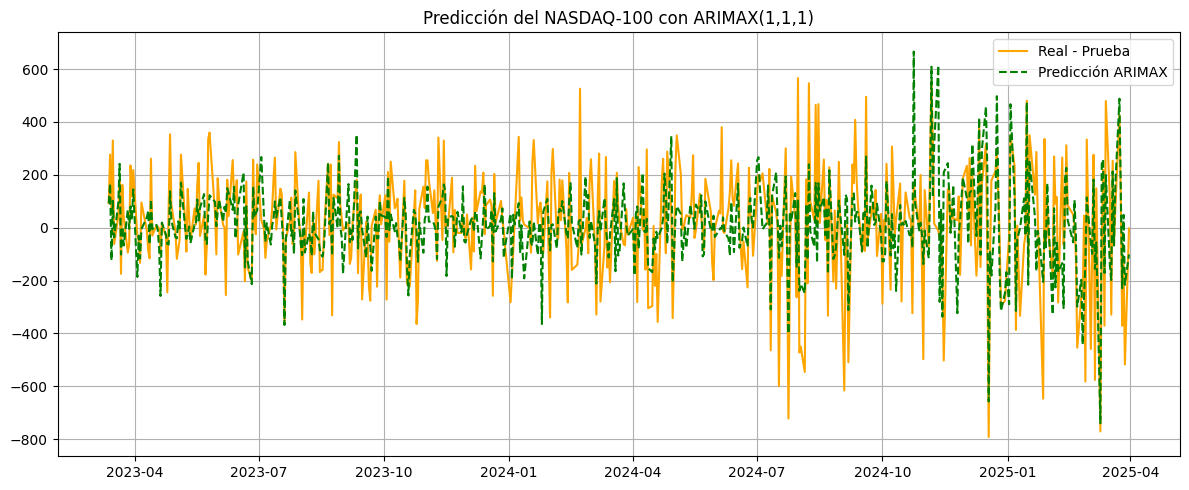

In [ ]:
# Se realizan las predicciones en el conjunto de prueba #
pred_arimax = resultado_arimax.forecast(steps=len(y_test), exog=X_test)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(y_train, label='Entrenamiento')
plt.plot(y_test, label='Real - Prueba', color='orange')
plt.plot(y_test.index, pred_arimax, label='Predicción ARIMAX', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con ARIMAX(1,1,1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo ARIMAX(1,1,1) - DataFrame Diferenciado:")

# RMSE #
rmse = np.sqrt(mean_squared_error(y_test, pred_arimax))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(y_test, pred_arimax)
print(f"MAE: {mae:.4f}")

# R^2 - Entrenamiento #
r2_train = r2_score(y_train, pred_arimax_train)
print(f"R^2 - Train: {r2_train:.4f}")

# R^2 - Test #
r2_test = r2_score(y_test, pred_arimax)
print(f"R^2 - Test: {r2_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_arimax.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_arimax.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_ARIMAX = {
    "modelo": "ARIMAX(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2_train": r2_train,
    "r2_test": r2_test,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo ARIMAX(1,1,1) - DataFrame Diferenciado:
RMSE: 165.6857
MAE: 127.9834
R^2 - Train: 0.3661
R^2 - Test: 0.3576
AIC:  25307.63
BIC:  25347.04


De esta manera, se observa que el modelo ARIMAX(1,1,1) aplicado a los datos diferenciados muestra un rendimiento bajo en términos de la varianza explicada, teniendo un valor de R^2 alrededor del 36% tanto en entrenamiento como en prueba.

Por otro lado, los valores de RMSE y MAE proporcionan una idea de la magnitud de los errores de predicción en las unidades de los datos diferenciados, en donde se tiene un RMSE igual a 165 puntos y MAE igual a 127 puntos.

La similitud entre los valores de R^2 tanto para el conjunto de entrenamiento como de prueba, sugiriendo una buena generalización, aunque el ajuste general no sea muy alto.

En conclusión, el modelo ARIMAX(1,1,1) en los datos diferenciados, muestra una capacidad de predicción baja pero consistente entre los conjuntos de entrenamiento y prueba.

#### 4.1.4. Modelo SARIMA

Al realizar la construcción de un modelo SARIMA (Seasonal ARIMA), este permitirá capturar patrones estacionales, además de las tendencias y dependencias temporales que ARIMA ya modela, lo que es especialmente útil en este caso, ya que se observaron patrones que se repiten anualmente en el índice ^NDX.

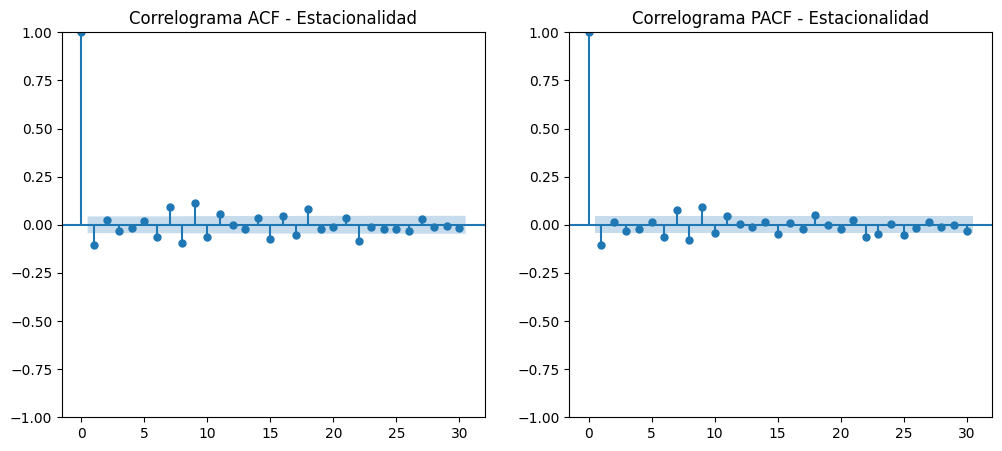

In [ ]:
# En primer lugar se grafican el ACF y el PACF para identificar estacionalidad #
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(ndx_train.dropna(), ax=ax[0], lags=30)
sm.graphics.tsa.plot_pacf(ndx_train.dropna(), ax=ax[1], lags=30)
ax[0].set_title("Correlograma ACF - Estacionalidad")
ax[1].set_title("Correlograma PACF - Estacionalidad")
plt.show()

In [ ]:
# Se definen los parámetros del modelo SARIMA #
p, d, q = 1, 1, 1  # Valores según ACF/PACF
P, D, Q, s = 1, 1, 1, 21  # Estacionalidad detectada leve

# Ajustar el modelo SARIMA #
modelo_sarima = SARIMAX(ndx_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
resultado_sarima = modelo_sarima.fit()

# Mostrar resumen del modelo
print(resultado_sarima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               ^NDX   No. Observations:                 2060
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 21)   Log Likelihood              -13033.146
Date:                            Wed, 30 Apr 2025   AIC                          26076.293
Time:                                    13:49:41   BIC                          26104.392
Sample:                                         0   HQIC                         26086.600
                                           - 2060                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0996      0.013     -7.763      0.000      -0.125      -0.074
ma.L1         -0.9999      0.030   

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


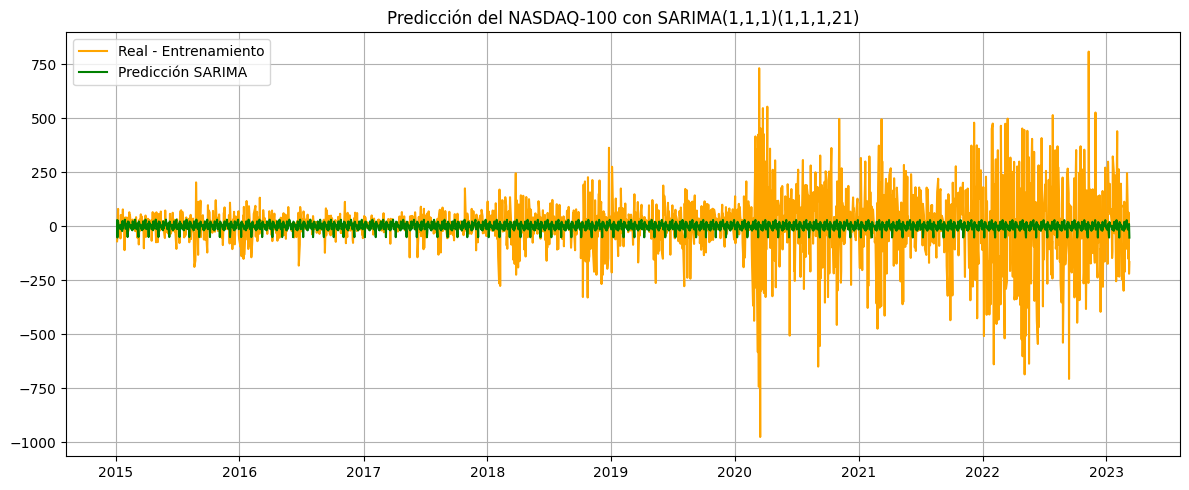

In [ ]:
# Se realizan las predicciones en el conjunto de entrenamiento #
pred_sarima_train = resultado_sarima.forecast(steps=len(ndx_train))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_train, label='Real - Entrenamiento', color='orange')
plt.plot(ndx_train.index, pred_sarima_train, label='Predicción SARIMA', color='green')
plt.title('Predicción del NASDAQ-100 con SARIMA(1,1,1)(1,1,1,21)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


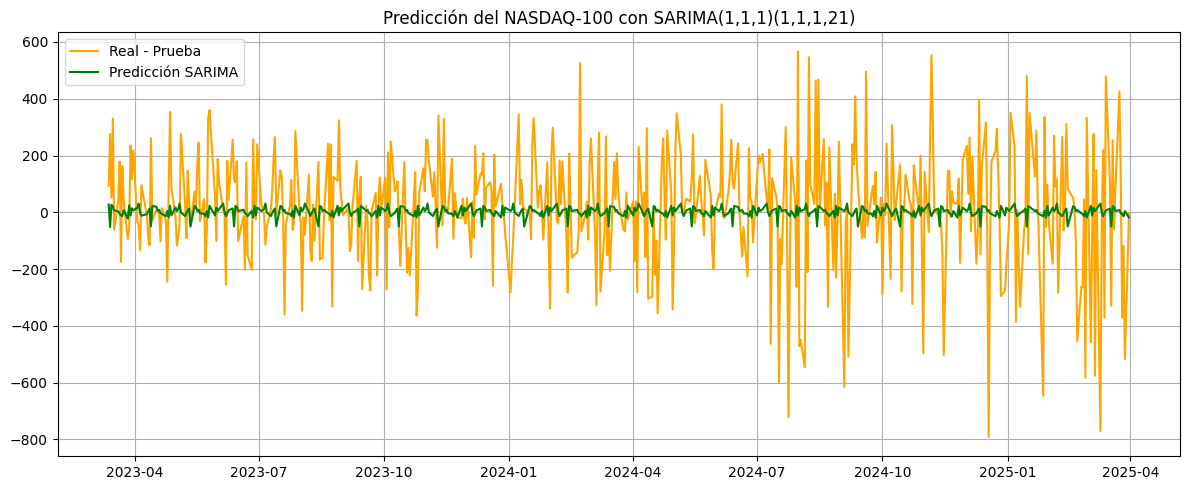

In [ ]:
# Se realizan las predicciones en el conjunto de prueba #
pred_sarima = resultado_sarima.forecast(steps=len(ndx_test))

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, pred_sarima, label='Predicción SARIMA', color='green')
plt.title('Predicción del NASDAQ-100 con SARIMA(1,1,1)(1,1,1,21)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo SARIMA(1,1,1)(1,1,1,21) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(ndx_test, pred_sarima))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(ndx_test, pred_sarima)
print(f"MAE: {mae:.4f}")

# R^2 - Entrenamiento #
r2_train = r2_score(ndx_train, pred_sarima_train)
print(f"R^2 - Train: {r2_train:.4f}")

# R^2 - Test #
r2_test = r2_score(ndx_test, pred_sarima)
print(f"R^2 - Test: {r2_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_sarima.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_sarima.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_SARIMA = {
    "modelo": "SARIMA(1,1,1,21)(1,1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2_train": r2_train,
    "r2_test": r2_test,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo SARIMA(1,1,1)(1,1,1,21) - Serie NDX Diferenciada:
RMSE: 208.2126
MAE: 155.6623
R^2 - Train: -0.0165
R^2 - Test: -0.0145
AIC:  26076.29
BIC:  26104.39


Estos resultados indican que el modelo SARIMA(1,1,1)(1,1,1,21) no está capturando adecuadamente la estructura de la serie diferenciada del ^NDX, al tener un RMSE alto (208.2126) y MAE alto (155.6623), indicando que el modelo tiene errores significativos en sus predicciones, lo que sugiere que no está ajustando bien los datos reales. Un buen modelo tendría un RMSE y MAE más bajos, mostrando que las predicciones están más cerca de los valores reales.

Este modelo tiene valores de R^2 negativos para los conjuntos de entrenamiento y prueba, lo que indica que no tiene una capacidad explicativa y básicamente el modelo no está explicando ninguna variabilidad de la serie de datos, ni mejorando con respecto a una simple media constante. Esto indica que la estacionalidad introducida en SARIMA no es relevante o que la serie no presenta un patrón estacional significativo.

Por último, se tienen valores AIC/BIC muy altos (26076.29 / 26104.39), lo que sugieren que el modelo es complejo, pero no mejora el ajuste.

Estos resultados concluyen que la estacionalidad no parece tener un impacto significativo.

#### 4.1.5. Modelo GARCH

El modelo GARCH (Generalized Autoregressive Conditional Heteroskedasticity) es usado para capturar y predecir la volatilidad de una serie financiera, como el NASDAQ-100 (^NDX), que a diferencia de ARIMA, que modela el nivel de la serie, GARCH modela la varianza condicional, es decir, cómo varía la volatilidad a lo largo del tiempo.

Como se vio antes del ajuste del modelo ARIMA, se concluyo que la serie quedo diferenciada, de manera que se vuelve estacionaria, y así, es posible ajustar el modelo GARCH.

In [ ]:
# Se define el modelo GARCH sobre la serie de log-retornos #
modelo_garch = arch_model(ndx_train.dropna(), vol="Garch", p=1, q=1)

# Se ajusta el modelo #
resultado_garch = modelo_garch.fit()

# Se muestra el resumen del modelo #
print(resultado_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 16641.228638867222
Iteration:      2,   Func. Count:     12,   Neg. LLF: 12261.871356946946
Iteration:      3,   Func. Count:     17,   Neg. LLF: 17119.246304977554
Iteration:      4,   Func. Count:     24,   Neg. LLF: 12261.801159876311
Iteration:      5,   Func. Count:     29,   Neg. LLF: 12261.738324702143
Iteration:      6,   Func. Count:     34,   Neg. LLF: 12261.281307511963
Iteration:      7,   Func. Count:     39,   Neg. LLF: 12258.59871173343
Iteration:      8,   Func. Count:     44,   Neg. LLF: 12243.125028934315
Iteration:      9,   Func. Count:     49,   Neg. LLF: 12276.551307414153
Iteration:     10,   Func. Count:     55,   Neg. LLF: 12273.131294596613
Iteration:     11,   Func. Count:     61,   Neg. LLF: 12270.360225413762
Iteration:     12,   Func. Count:     67,   Neg. LLF: 12260.068154988132
Iteration:     13,   Func. Count:     73,   Neg. LLF: 12220.943233905447
Iteration:     14,   Func. Count:     78,   Neg. LLF

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.02e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


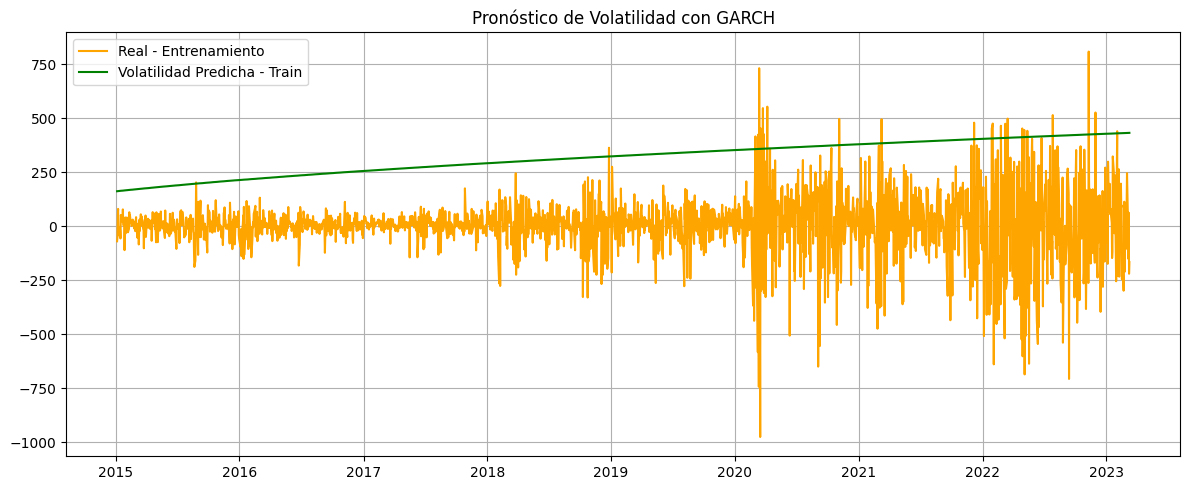

In [ ]:
# Se realizan las predicciones en el conjunto de entrenamiento #
pred_garch_train = resultado_garch.forecast(horizon=len(ndx_train))

# Se extrae la desviación estándar pronosticada (volatilidad) #
volatilidad_predicha_train = np.sqrt(pred_garch_train.variance.values[-1, :])

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_train.index, ndx_train, label='Real - Entrenamiento', color='orange')
plt.plot(ndx_train.index, volatilidad_predicha_train, label='Volatilidad Predicha - Train', color='green')
plt.title('Pronóstico de Volatilidad con GARCH')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

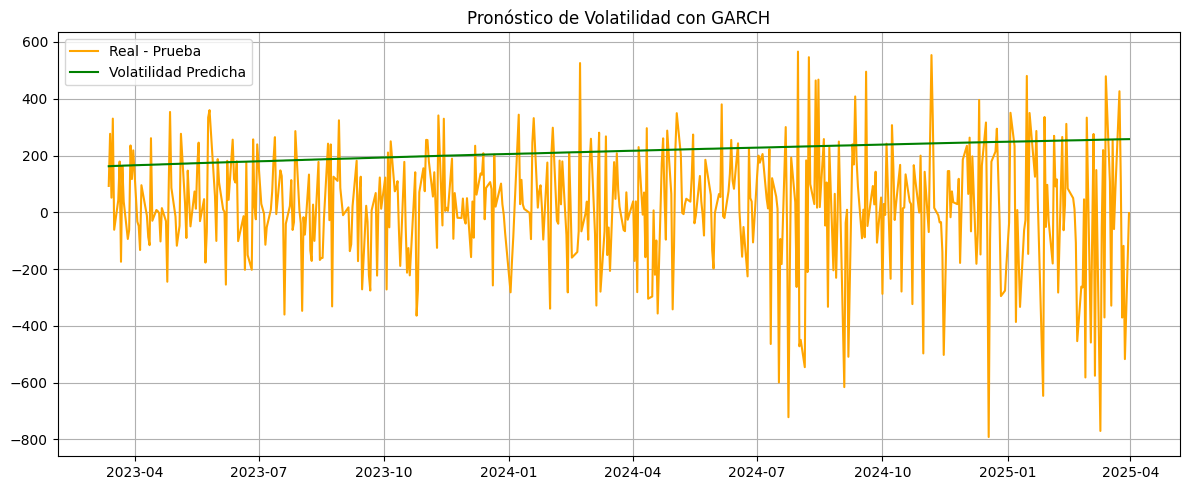

In [ ]:
# Se realizan las predicciones en el conjunto de prueba #
pred_garch = resultado_garch.forecast(horizon=len(ndx_test))

# Se extrae la desviación estándar pronosticada (volatilidad) #
volatilidad_predicha = np.sqrt(pred_garch.variance.values[-1, :])

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
#plt.plot(ndx_train, label='Entrenamiento')
plt.plot(ndx_test.index, ndx_test, label='Real - Prueba', color='orange')
plt.plot(ndx_test.index, volatilidad_predicha, label='Volatilidad Predicha', color='green')
plt.title('Pronóstico de Volatilidad con GARCH')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo GARCH(1,1) - Serie NDX Diferenciada:")

# RMSE #
rmse = np.sqrt(mean_squared_error(np.abs(ndx_test), volatilidad_predicha))
print(f"RMSE: {rmse:.4f}")

# MAE #
mae = mean_absolute_error(np.abs(ndx_test), volatilidad_predicha)
print(f"MAE: {mae:.4f}")

# R^2 - Entrenamiento #
r2_train = r2_score(np.abs(ndx_train), volatilidad_predicha_train)
print(f"R^2 - Entrenamiento: {r2_train:.4f}")

# R^2 - Test #
r2_test = r2_score(np.abs(ndx_test), volatilidad_predicha)
print(f"R^2 - Prueba: {r2_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = resultado_garch.aic
print(f"AIC:  {aic:.2f}")
bic = resultado_garch.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_GARCH = {
    "modelo": "GARCH(1,1)",
    "rmse": rmse,
    "mae": mae,
    "r2_train": r2_train,
    "r2_test": r2_test,
    "aic": aic,
    "bic": bic
}

Evaluación del modelo GARCH(1,1) - Serie NDX Diferenciada:
RMSE: 146.4193
MAE: 122.9495
R^2 - Entrenamiento: -4.0963
R^2 - Prueba: -0.1248
AIC:  24447.17
BIC:  24469.69


### 4.2. Modelos de Machine Learning

#### 4.2.1. Modelo de Regresión Lineal Simple en función del tiempo

Para entrar al mundo multivariado con machine learning, se comenzará con el modelo clásico de Regresión Lineal Simple, lo cual es ideal para establecer una línea base. Sin embargo, este primero se ajustará para la variable del NASDAQ-100 en función del tiempo.

In [ ]:
# En primer lugar, se convierte la columna 'Fecha' en formato numérico desde el inicio #
data = df_close2.copy()

# Se crea una columna de tiempo basada en el índice del DataFrame #
data["Tiempo"] = range(1, len(data) + 1)

##### * Validación de supuestos *

En primer lugar se hará la validación de supuestos, empezando por el supuesto de linealidad:

In [ ]:
# Se ajusta el modelo preliminar #
X = sm.add_constant(data["Tiempo"])
modelo_temp = sm.OLS(data["^NDX"], X).fit()
residuos = modelo_temp.resid
data['residuos'] = modelo_temp.resid
data['ajustado'] = modelo_temp.fittedvalues

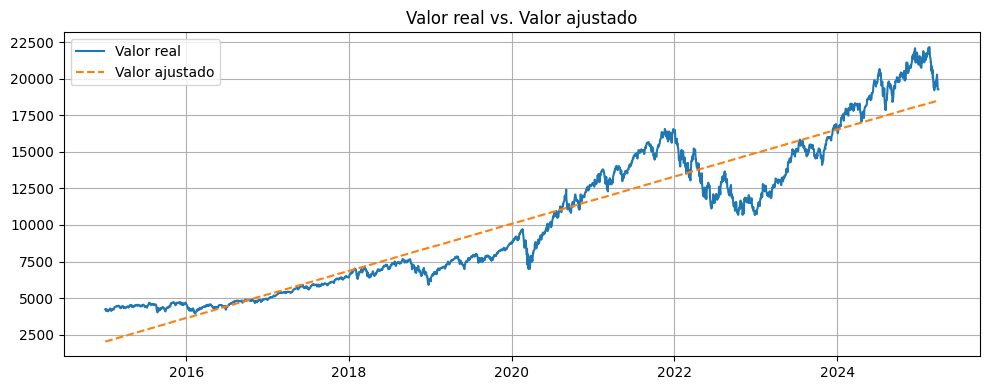

In [ ]:
# Supuesto de linealidad #
plt.figure(figsize=(10, 4))
plt.plot(data['^NDX'], label='Valor real')
plt.plot(data['ajustado'], label='Valor ajustado', linestyle='--')
plt.title('Valor real vs. Valor ajustado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Se revisa ahora el test de Durbin-Watson para validar el supuesto de independencia

In [ ]:
# Test de Durbin-Watson #
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuos)
print(f"Durbin-Watson Statistic: {dw_stat}")

Durbin-Watson Statistic: 0.009435765968531944


Este test dice que si la estadística de Durbin-Watson es más o menos igual a 2, los errores no tienen autocorrelación significativa. Sin embargo, se ve que en este caso, la estadística es cercana a cero, lo que indica que los errores pueden tener autocorrelación significativa.

Luego, se implementará el supuesto de Homocedasticidad (Varianza Constante de los Errores) por medio del Test de Breusch-Pagan:

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuos, X)
print(f"Breusch-Pagan p-value: {bp_test[1]}")

Breusch-Pagan p-value: 6.288737064833052e-106


Este test indica que si el p-value es mayor a 0.05, los errores tienen varianza constante. Pero se observa que son cercanos a cero, por lo que se rechaza la hipótesis nula de que los errores tienen varianza constante.

Por último, se probará el test de Normalidad de los Errores por medio de un histograma y el Test de Shapiro-Wilk:

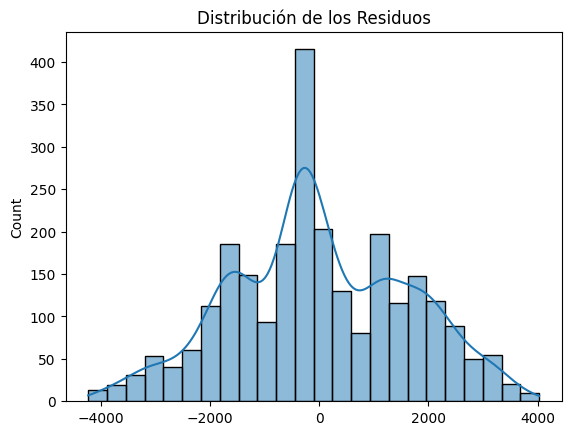

Shapiro-Wilk p-value: 3.934297904635842e-12


In [ ]:
sns.histplot(residuos, kde=True)
plt.title("Distribución de los Residuos")
plt.show()

shapiro_test = stats.shapiro(residuos)
print(f"Shapiro-Wilk p-value: {shapiro_test[1]}")

Este test indica que si el p-value es mayor a 0.05, los residuos siguen una distribución normal, lo cual en este caso tampoco sucede y por ende, los errores no siguen una distribución normal.

Al no cumplir los supuestos de normalidad la variable ^NDX en función del tiempo, se concluye que no sería correcto ajustar un modelo de regresión lineal en este caso. Es por esto que se procederá a hacer una transformación que permita hacer el modelo en cuestión.

Para ello se transformará la serie.

In [ ]:
from scipy.stats import boxcox
ndx_positive = data.drop(columns=["TSLA", "^TNX",	"DX-Y.NYB",	"DX-Y.NYB"])
df_boxcox = ndx_positive.loc[ndx_positive.index].copy()

# Transformación Box-Cox #
df_boxcox['NDX_boxcox'], fitted_lambda = boxcox(df_boxcox['^NDX'])

# Modelo con Box-Cox
X_box = df_boxcox[['Tiempo']]
y_box = df_boxcox['NDX_boxcox']

model_box = LinearRegression()
model_box.fit(X_box, y_box)
df_boxcox['pred_box'] = model_box.predict(X_box)
df_boxcox['resid_box'] = y_box - df_boxcox['pred_box']

Durbin-Watson Statistic: 0.013984321479334198
Breusch-Pagan p-value: 1.8136124468323665e-40


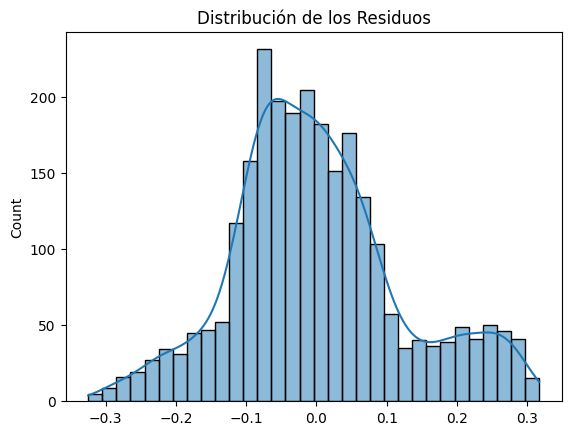

Shapiro-Wilk p-value: 1.1662168229928595e-20


In [ ]:
# Se vuelve a probar los supuestos de normalidad en los residuos #
# Se ajusta el modelo preliminar #
X2 = sm.add_constant(df_boxcox["Tiempo"])
modelo_temp2 = sm.OLS(df_boxcox["NDX_boxcox"], X2).fit()
residuos2 = modelo_temp2.resid

# Test de Durbin-Watson #
dw_stat2 = durbin_watson(residuos2)
print(f"Durbin-Watson Statistic: {dw_stat2}")

# Test de Breusch-Pagan #
bp_test2 = het_breuschpagan(residuos2, X2)
print(f"Breusch-Pagan p-value: {bp_test2[1]}")

# Distribución de los residuos #
sns.histplot(residuos2, kde=True)
plt.title("Distribución de los Residuos")
plt.show()

# Test de Shapiro Wilk #
shapiro_test2 = stats.shapiro(residuos2)
print(f"Shapiro-Wilk p-value: {shapiro_test2[1]}")

Al hacer la transformación de Box-Cox se encontró que de esta manera, los datos tampoco cumplen con los supuestos de normalidad, lo que indica que no sería conveniente ajustar un modelo de regresión lineal.

Sin embargo, por practicidad del ejercicio y por dejar ejemplificado, se procederá a establecer un modelo suponiendo que si se cumplen los supuestos de normalidad.

En primer lugar, se dividirá el conjunto de entrenamiento y prueba para el modelo:

In [ ]:
# Se prepara la serie del Nasdaq #
serie_ndx = df_close2['^NDX'].dropna().asfreq('B').ffill()

# Se crea una variable lag de 1 día #
df_lr = pd.DataFrame()
df_lr['t'] = serie_ndx
df_lr['t-1'] = serie_ndx.shift(1)
df_lr = df_lr.dropna() # Se eliminan valores nulos generados por el lag

# Se dividen en conjunto de entrenamiento y prueba #
n = len(df_lr)
n_train = int(n * 0.8) # 80% en entrenamiento

df_train = df_lr.iloc[:n_train]
df_test = df_lr.iloc[n_train:]

# División de conjuntos #
# Entrenamiento #
X_train = df_train['t-1']
y_train = df_train['t']

# Prueba #
X_test = df_test['t-1']
y_test = df_test['t']

In [ ]:
# Se realiza el ajuste del modelo #
X_train_const = sm.add_constant(X_train)  # Se agrega el intercepto (constante)
modelo_rl = sm.OLS(y_train, X_train_const).fit()

# Summary del modelo #
print(modelo_rl.summary())

                            OLS Regression Results                            
Dep. Variable:                      t   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.442e+06
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:22:35   Log-Likelihood:                -13579.
No. Observations:                2136   AIC:                         2.716e+04
Df Residuals:                    2134   BIC:                         2.717e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6989      7.649      1.399      0.1

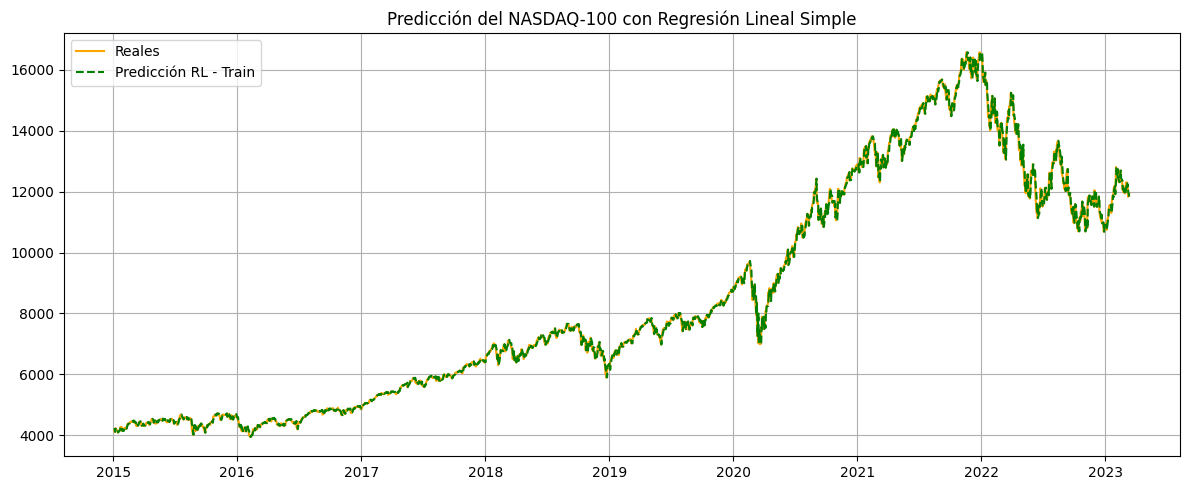

In [ ]:
# Se hace predicción según el modelo ajustado
X_train_const = sm.add_constant(X_train)
pred_rl_train = modelo_rl.predict(X_train_const)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
# plt.plot(X_train.index, X_train.values, label='Histórico', color='black')
plt.plot(y_train.index, y_train.values, label='Reales', color='orange')
plt.plot(y_train.index, pred_rl_train.values, label='Predicción RL - Train', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Simple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

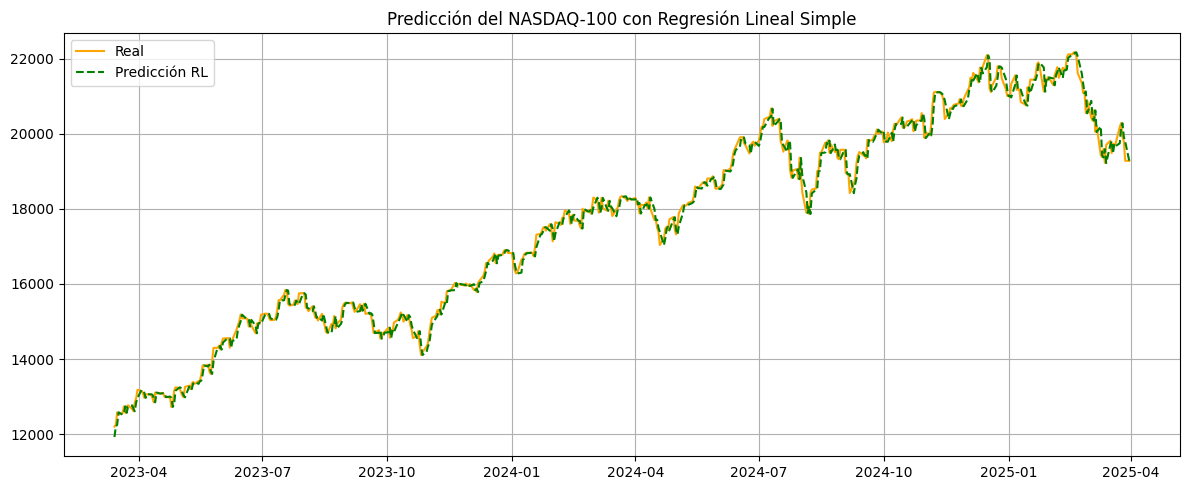

In [ ]:
# Se hace predicción según el modelo ajustado
X_test_const = sm.add_constant(X_test)
pred_rl = modelo_rl.predict(X_test_const)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
# plt.plot(X_train.index, X_train.values, label='Histórico', color='black')
plt.plot(y_test.index, y_test.values, label='Real', color='orange')
plt.plot(y_test.index, pred_rl.values, label='Predicción RL', linestyle="dashed", color='green')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Simple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Regresión Lineal en función del Tiempo:")

# RMSE #
rmse_rl = np.sqrt(mean_squared_error(y_test, pred_rl))
print(f"RMSE: {rmse_rl:.4f}")

# MAE #
mae_rl = mean_absolute_error(y_test, pred_rl)
print(f"MAE: {mae_rl:.4f}")

# R^2 - Entrenamiento #
r2_rl_train = r2_score(y_train, pred_rl_train)
print(f"R^2 - Train: {r2_rl_train:.4f}")

# R^2 - Prueba #
r2_rl_test = r2_score(y_test, pred_rl)
print(f"R^2: {r2_rl_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = modelo_rl.aic
print(f"AIC:  {aic:.2f}")
bic = modelo_rl.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_reg_lineal = {
    "modelo": "Regresión Lineal simple",
    "rmse": rmse_rl,
    "mae": mae_rl,
    "r2_train": r2_rl_train,
    "r2_test": r2_rl_test,
    "aic": modelo_rl.aic,
    "bic": modelo_rl.bic
}

Evaluación del modelo de Regresión Lineal en función del Tiempo:
RMSE: 203.4022
MAE: 149.2571
R^2 - Train: 0.9985
R^2: 0.9942
AIC:  27162.87
BIC:  27174.20


#### 4.2.2. Modelo de Regresión Lineal Múltiple

Como se observó anteriormente, no sería correcto ajusta un modelo de la variable NDX en función del tiempo ya que no se cumplen los supuestos de normalidad. Ahora, se ajustará un modelo de Regresión Lineal Múltiple con el fin de ver si el comportamiento del NASDAQ-100 (^NDX) puede explicarse con ayuda de otras variables bursátiles.

##### * Validación de supuestos *

In [ ]:
df_mult = df_close2[['^NDX', "TSLA", "^TNX",	"DX-Y.NYB",	"DX-Y.NYB"]].dropna()
df_mult = df_mult.rename(columns={'^NDX': 'Y'})  # variable objetivo

X = df_mult.drop(columns='Y')
X = sm.add_constant(X)  # agregar constante
y = df_mult['Y']

# Ajuste del modelo de regresión múltiple #
modelo = sm.OLS(y, X).fit()
df_mult['residuos'] = modelo.resid
df_mult['ajustados'] = modelo.fittedvalues

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     4220.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:32:23   Log-Likelihood:                -23320.
No. Observations:                2576   AIC:                         4.665e+04
Df Residuals:                    2572   BIC:                         4.667e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8031.3456   1079.820      7.438      0.0

En primer lugar se hará la validación de supuestos, empezando por Relación Lineal entre la Variable Dependiente y las Predictoras

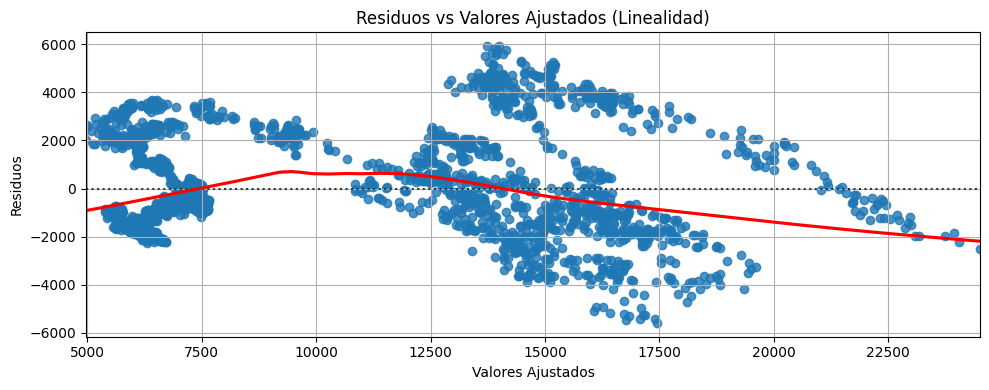

In [ ]:
## Linealidad: residuos vs valores ajustados #
plt.figure(figsize=(10, 4))
sns.residplot(x=df_mult['ajustados'], y=df_mult['residuos'], lowess=True, line_kws={'color': 'red'})
plt.title('Residuos vs Valores Ajustados (Linealidad)')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.grid(True)
plt.tight_layout()
plt.show()

Se observa que los residuos no son lineales con respecto a los valores ajustados, de manera que no se cunmple el supuesto de linealidad.

Ahora, se revisará la independencia de los Errores. Para ello se hará uso del test de Durbin-Watson:

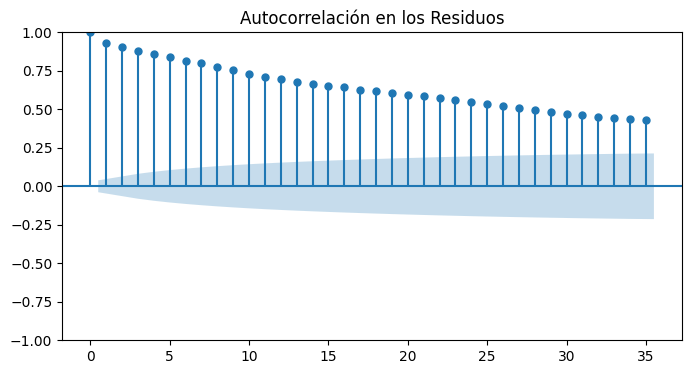


Durbin-Watson Statistic: 0.0089 (valor cercano a 2 indica independencia)


In [ ]:
# Ajustar modelo preliminar para obtener residuos #
modelo_temp = sm.OLS(df_close["^NDX"], sm.add_constant(df_close.drop(columns=["^NDX"]))).fit()
residuos = modelo_temp.resid

# Se grafica el ACF de los residuos #
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuos, ax=ax)
plt.title("Autocorrelación en los Residuos")
plt.show()

# Test de Durbin-Watson #
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(df_mult['residuos'])
print(f"\nDurbin-Watson Statistic: {dw_stat:.4f} (valor cercano a 2 indica independencia)")

Este test dice que si la estadística de Durbin-Watson es más o menos igual a 2, los errores no tienen autocorrelación significativa. SIn embargo, se ve que en este caso, la estadística es cercana a cero, lo que indica que los errores pueden tener autocorrelación significativa, además de que el ACF muestra una alta correlación.

Luego, se implementará el supuesto de Homocedasticidad (Varianza Constante de los Errores) por medio del Test de Breusch-Pagan:

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Aplicar la prueba de Breusch-Pagan #
bp_test = het_breuschpagan(df_mult['residuos'], X)
labels = ['LM stat', 'p-value', 'F-stat', 'F p-value']
print("\nBreusch-Pagan Test:")
for name, val in zip(labels, bp_test):
    print(f"{name}: {val:.4f}")


Breusch-Pagan Test:
LM stat: 610.2183
p-value: 0.0000
F-stat: 266.1336
F p-value: 0.0000


Este test indica que si el p-value es mayor a 0.05, los errores tienen varianza constante. Pero se observa que son iguales a cero, por lo que se rechaza la hipótesis nula de que los errores tienen varianza constante.

Luego, se prueba el test de Normalidad de los Errores por medio de gráficos y los Test de Shapiro-Wilk y Jarque-Bera:

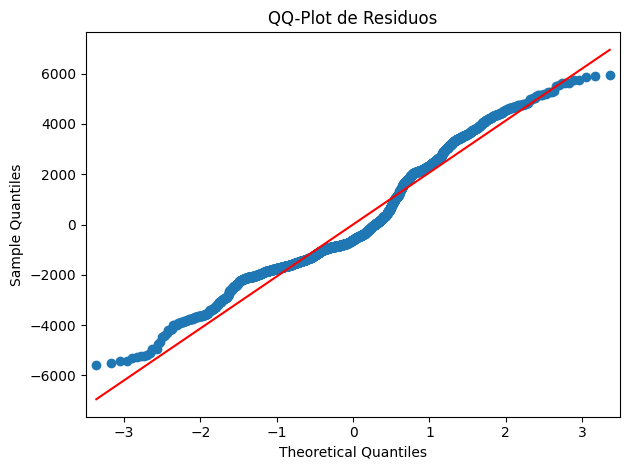

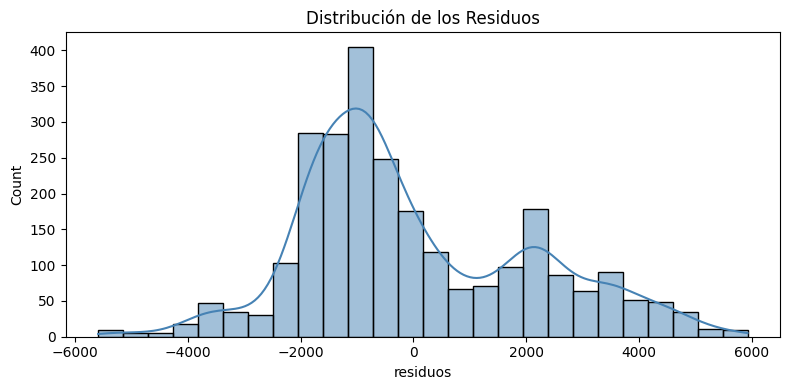


Shapiro-Wilk Test: Statistic=0.9525, p-value=0.0000
Jarque-Bera Test: Statistic=133.7151, p-value=0.0000


In [ ]:
# Grafico QQ Plot residuos #
from statsmodels.graphics.gofplots import qqplot
qqplot(df_mult['residuos'], line='s')
plt.title('QQ-Plot de Residuos')
plt.tight_layout()
plt.show()

# Graficar distribución de los residuos #
plt.figure(figsize=(8, 4))
sns.histplot(df_mult['residuos'], kde=True, color='steelblue')
plt.title('Distribución de los Residuos')
plt.tight_layout()
plt.show()

# Test de Shapiro-Wilk y Jarque-Bera #
shapiro_stat, shapiro_p = shapiro(df_mult['residuos'])
jb_stat, jb_p = jarque_bera(df_mult['residuos'])

print(f"\nShapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
print(f"Jarque-Bera Test: Statistic={jb_stat:.4f}, p-value={jb_p:.4f}")

Estos tests indican que si el p-value es mayor a 0.05, los residuos siguen una distribución normal, lo cual en este caso tampoco sucede y por ende, los errores no siguen una distribución normal.

Por último, se validará el supuesto de No Multicolinealidad Entre las Variables Predictoras, para el cual se usará el VIF (Factor de Inflación de la Varianza):

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcular VIF #
vif_df = pd.DataFrame()
vif_df['Variable'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF (Factor de Inflación de la Varianza):")
print(vif_df)


VIF (Factor de Inflación de la Varianza):
   Variable         VIF
0     const  701.700430
1      TSLA    1.234209
2      ^TNX    2.070962
3  DX-Y.NYB         inf
4  DX-Y.NYB         inf


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Este test indica que si el valor de VIF es menor a 5 para todas las variables, no hay multicolinealidad severa y podemos proceder con la regresión, pero en este caso no sucede de esta manera.

Partiendo de esto, se concluye que un modelo de regresión lineal múltiple no seria el adecuado al igual que el inciso anterior. Sin embargo, por practicidad del ejercicio y por dejar ejemplificado, se procederá a establecer un modelo suponiendo que si se cumplen los supuestos de normalidad.

In [ ]:
# En primer lugar se hace la selección del objetivo y variables exógenas #
variables = ["TSLA", "^TNX",	"DX-Y.NYB",	"DX-Y.NYB"]
df_regresion = df_close2[['^NDX'] + variables].dropna().asfreq('B').ffill()

# Luego, se hace la división en conjunto de entrenamiento y prueba #
n = len(df_regresion)
n_train = int(n * 0.8)

df_train = df_regresion.iloc[:n_train]
df_test = df_regresion.iloc[n_train:]

X_train = df_train[variables]
y_train = df_train['^NDX']
X_test = df_test[variables]
y_test = df_test['^NDX']

In [ ]:
# Ajuste del modelo múltiple #
X_train_const = sm.add_constant(X_train)  # Intercepto
modelo_rlm = sm.OLS(y_train, X_train_const).fit()

# Summary del modelo #
print(modelo_rlm.summary())

                            OLS Regression Results                            
Dep. Variable:                   ^NDX   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     4515.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:34:00   Log-Likelihood:                -18418.
No. Observations:                2137   AIC:                         3.684e+04
Df Residuals:                    2133   BIC:                         3.687e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.148e+04    700.406     16.395      0.0

Al tener todas las variables un valor p < 0.05, se dice que todas las variables escogidas (activos bursátiles), son significativas para el modelado del comportamiento del Nasdaq-100.

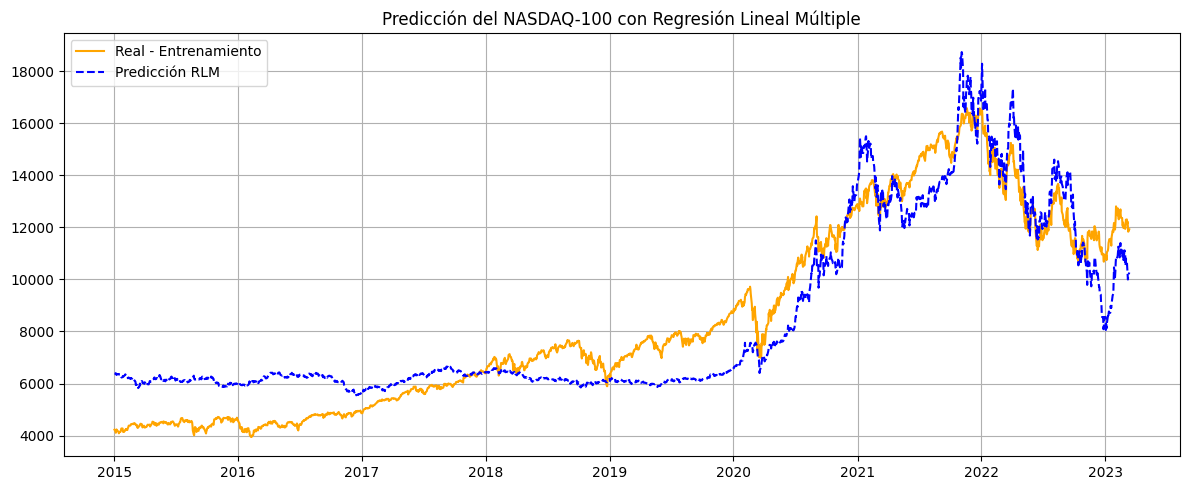

In [ ]:
# Predicciones según el modelo #
X_train_const = sm.add_constant(X_train)
pred_rlm_train = modelo_rlm.predict(X_train_const)

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train.values, label='Real - Entrenamiento', color='orange')
plt.plot(y_train.index, pred_rlm_train.values, label='Predicción RLM', linestyle = "dashed", color='blue')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Múltiple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

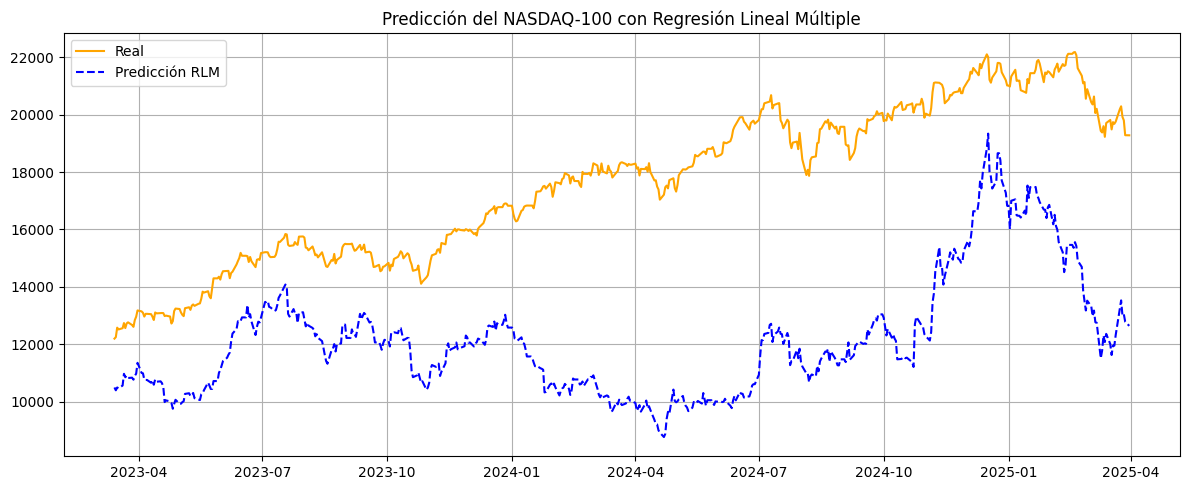

In [ ]:
# Predicciones según el modelo #
X_test_const = sm.add_constant(X_test)
pred_rlm = modelo_rlm.predict(X_test_const)

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Real', color='orange')
plt.plot(y_test.index, pred_rlm.values, label='Predicción RLM', linestyle = "dashed", color='blue')
plt.title('Predicción del NASDAQ-100 con Regresión Lineal Múltiple')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Regresión Lineal Múltiple:")

# RMSE #
rmse_rlm = np.sqrt(mean_squared_error(y_test, pred_rlm))
print(f"RMSE: {rmse_rlm:.4f}")

# MAE #
mae_rlm = mean_absolute_error(y_test, pred_rlm)
print(f"MAE: {mae_rlm:.4f}")

# R^2 - Entrenamiento #
r2_rlm_train = r2_score(y_train, pred_rlm_train)
print(f"R^2 - Train: {r2_rlm_train:.4f}")

# R^2 - Test #
r2_rlm_test = r2_score(y_test, pred_rlm)
print(f"R^2 - Test: {r2_rlm_test:.4f}")

# AIC y BIC solo si el modelo los tiene #
aic = modelo_rlm.aic
print(f"AIC:  {aic:.2f}")
bic = modelo_rlm.bic
print(f"BIC:  {bic:.2f}")

# Se guardan los resultados #
resultados_rl_multi = {
    "modelo": "Regresión Lineal Múltiple",
    "rmse": rmse_rlm,
    "mae": mae_rlm,
    "r2_train": r2_rlm_train,
    "r2_test": r2_rlm_test,
    "aic": modelo_rlm.aic,
    "bic": modelo_rlm.bic
}

Evaluación del modelo de Regresión Lineal Múltiple:
RMSE: 5945.8089
MAE: 5445.0695
R^2 - Train: 0.8640
R^2 - Test: -3.9827
AIC:  36844.51
BIC:  36867.18


#### 4.2.3. Modelo de Random Forest Regressor

Ahora, se ajustará un modelo de Random Forest Regressor, el cual puede funcionar muy bien con conjuntos de datos financieros donde las relaciones entre variables pueden ser complejas, no lineales y con mucha interacción.

In [ ]:
# En primer lugar se hace la selección del objetivo y variables exógenas #
variables = ["TSLA", "^TNX",	"DX-Y.NYB",	"DX-Y.NYB"]
df_rf = df_close2[['^NDX'] + variables].dropna().asfreq('B').ffill()

# Luego, se hace la división en conjunto de entrenamiento y prueba #
n = len(df_rf)
n_train = int(n * 0.8)

df_train = df_rf.iloc[:n_train]
df_test = df_rf.iloc[n_train:]

X_train = df_train[variables]
y_train = df_train['^NDX']
X_test = df_test[variables]
y_test = df_test['^NDX']

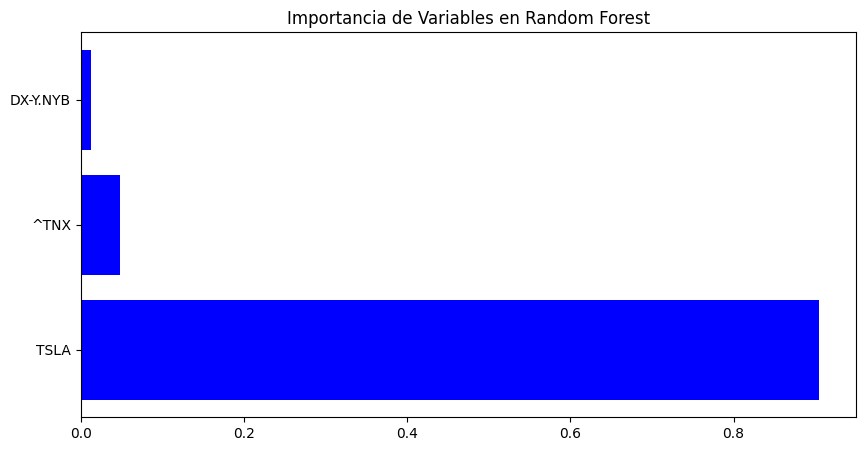

In [ ]:
# Entrenar modelo preliminar para evaluar importancia de variables #
modelo_rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf_temp.fit(X_train, y_train)

# Graficar importancia de características
importances = modelo_rf_temp.feature_importances_
features = df_rf[variables].columns

plt.figure(figsize=(10,5))
plt.barh(features, importances, color="blue")
plt.title("Importancia de Variables en Random Forest")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
# Se define el modelo base #
modelo_rf = RandomForestRegressor(random_state=42)

# Definir búsqueda de hiperparámetros #
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 4]
}

# Búsqueda de mejores hiperparámetros #
grid_search = GridSearchCV(modelo_rf, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor configuración encontrada #
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
# Entrenar el modelo con los mejores parámetros encontrados #
modelo_rf_final = RandomForestRegressor(**grid_search.best_params_, random_state=42)
modelo_rf_final.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=4, n_estimators=200, random_state=42)

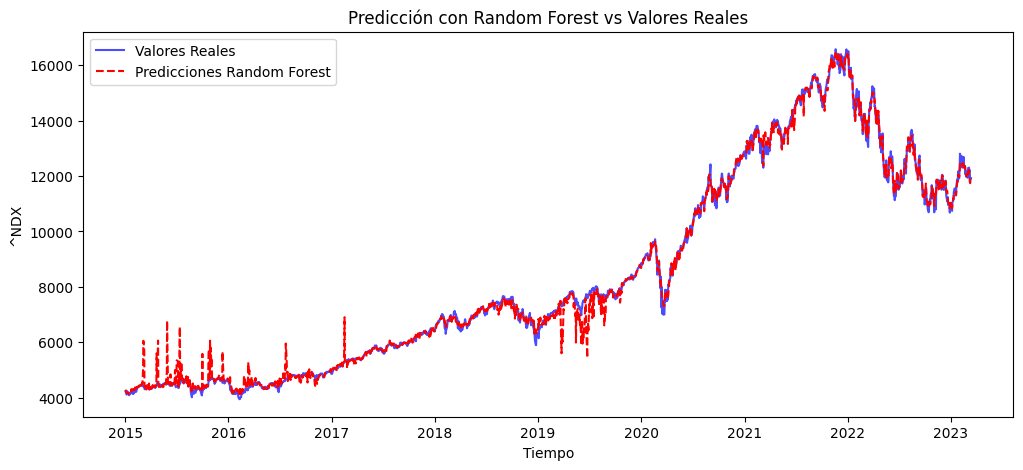

In [ ]:
# Predicción sobre el conjunto de entrenamiento #
y_pred_train = modelo_rf_final.predict(X_train)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label="Valores Reales", color="blue", alpha=0.7)
plt.plot(y_train.index, y_pred_train, linestyle="dashed", color="red", label="Predicciones Random Forest")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("^NDX")
plt.title("Predicción con Random Forest vs Valores Reales")
plt.show()

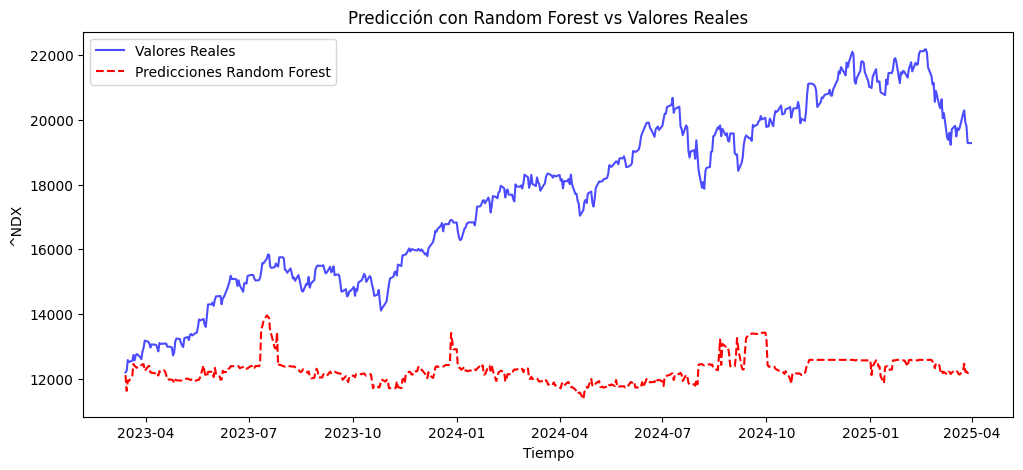

In [ ]:
# Predicción sobre el conjunto de prueba #
y_pred = modelo_rf_final.predict(X_test)

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Valores Reales", color="blue", alpha=0.7)
plt.plot(y_test.index, y_pred, linestyle="dashed", color="red", label="Predicciones Random Forest")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("^NDX")
plt.title("Predicción con Random Forest vs Valores Reales")
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de Random Forest Regressor:")

# RMSE #
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_rf:.4f}")

# MAE #
mae_rf = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_rf:.4f}")

# R^2 - Entrenamiento #
r2_rf_train = r2_score(y_train, y_pred_train)
print(f"R^2 - Train: {r2_rf_train:.4f}")

# R^2 - Prueba #
r2_rf_test = r2_score(y_test, y_pred)
print(f"R^2 - Test: {r2_rf_test:.4f}")

# AIC y BIC no tiene #

# Se guardan los resultados #
resultados_rf = {
    "modelo": "Random Forest",
    "rmse": rmse_rf,
    "mae": mae_rf,
    "r2_train": r2_rf_train,
    "r2_test": r2_rf_test,
    "aic": None,
    "bic": None
}

Evaluación del modelo de Random Forest Regressor:
RMSE: 5950.4713
MAE: 5350.9869
R^2 - Train: 0.9956
R^2 - Test: -3.9905


<ipython-input-104-de17cce7b265>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancias, x='Importancia', y='Variable', palette='viridis')


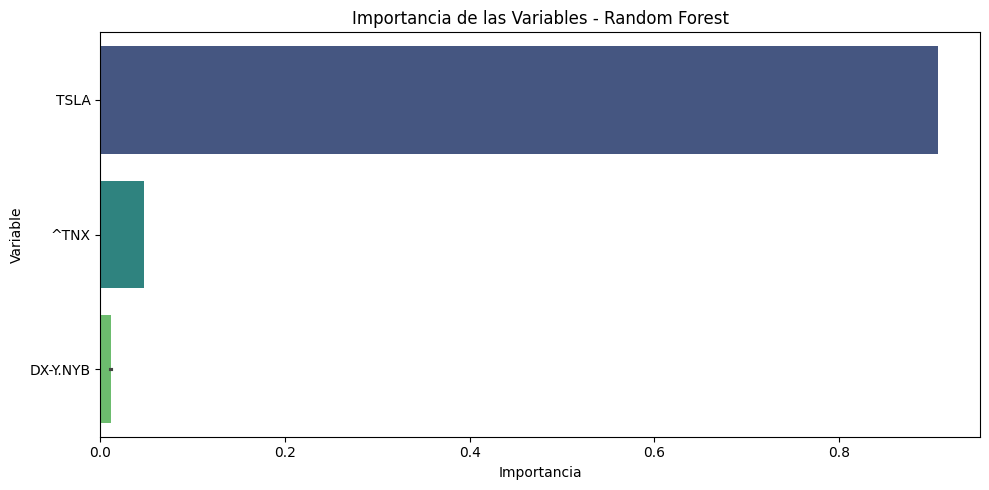

In [ ]:
# Se revisa la importancia de variables #
importancias = modelo_rf_final.feature_importances_
variables = X_train.columns

df_importancias = pd.DataFrame({
    'Variable': variables,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Visualización de las importancias #
plt.figure(figsize=(10, 5))
sns.barplot(data=df_importancias, x='Importancia', y='Variable', palette='viridis')
plt.title('Importancia de las Variables - Random Forest')
plt.tight_layout()
plt.show()

Inicialmente, se observa que solamente 1 activo es de gran importancia para el modelado de la serie del Nasdaq-100 "TSLA".

Sin embargo, se observa que se predice bien al inicio pero luego se daña la predicción. Esto se puede deber a que Random Forest no tiene "memoria" ni conciencia del tiempo, de manera que si no se incluyen explícitamente variables de fecha, lags o alguna estructura de tiempo, el modelo no puede entender la secuencia temporal.

#### 4.2.4. Modelo XGBoost

Este modelo suele tener un rendimiento superior para series temporales cuando se usan lags y/o características adicionales

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Se preparan los datos #
df_model = df_close2[['^NDX',"TSLA", "^TNX",	"DX-Y.NYB"]].dropna()
df_model = df_model.rename(columns={'^NDX': 'target'})

X = df_model.drop(columns='target')
y = df_model['target']

# Se escalan los datos #
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en conjunto de entrenamiento y prueba #
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [ ]:
# Se define el modelo base y parámetros para búsqueda #
from xgboost import XGBRegressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

In [ ]:
# Se entrena el modelo con la búsqueda de hiperparámetros #
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=1)


🏆 Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


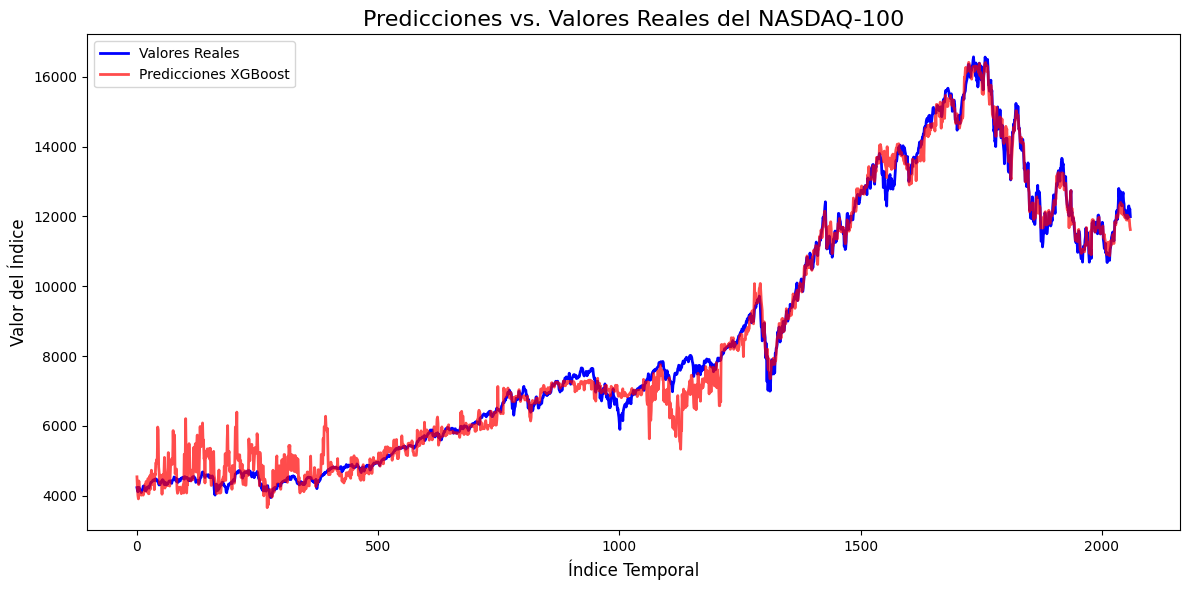

In [ ]:
# Predicciones con el ajuste del modelo - Entrenamiento #
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)

print("\n🏆 Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Visualización de las predicciones #
plt.figure(figsize=(12, 6))
plt.plot(y_train.values, label='Valores Reales', color='blue', linewidth=2)
plt.plot(y_pred_train, label='Predicciones XGBoost', color='red', linewidth=2, alpha=0.7)
plt.title('Predicciones vs. Valores Reales del NASDAQ-100', fontsize=16)
plt.xlabel('Índice Temporal', fontsize=12)
plt.ylabel('Valor del Índice', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


🏆 Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


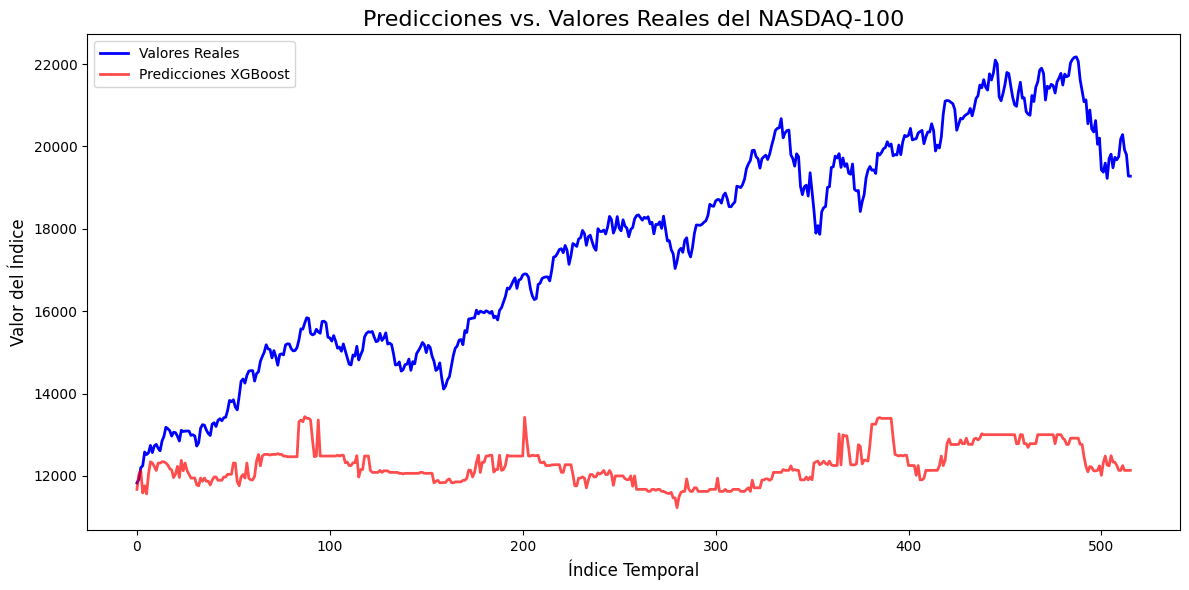

In [ ]:
# Predicciones con el ajuste del modelo - Prueba #
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n🏆 Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Visualización de las predicciones #
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Valores Reales', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicciones XGBoost', color='red', linewidth=2, alpha=0.7)
plt.title('Predicciones vs. Valores Reales del NASDAQ-100', fontsize=16)
plt.xlabel('Índice Temporal', fontsize=12)
plt.ylabel('Valor del Índice', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de XGBoost:")

# RMSE #
rmse_xgb = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse_xgb:.4f}")

# MAE #
mae_xgb = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae_xgb:.4f}")

# R^2 - Entrenamiento #
r2_xgb_train = r2_score(y_train, y_pred_train)
print(f"R^2 - Train: {r2_xgb_train:.4f}")

# R^2 - Prueba #
r2_xgb_test = r2_score(y_test, y_pred)
print(f"R^2 - Prueba: {r2_xgb_test:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_xgb = {
    "modelo": "XGBoost",
    "rmse": rmse_xgb,
    "mae": mae_xgb,
    "r2_train": r2_xgb_train,
    "r2_test": r2_xgb_test,
    "aic": None,
    "bic": None
}

Evaluación del modelo de XGBoost:
RMSE: 5881.8536
MAE: 5297.5742
R^2 - Train: 0.9880
R^2 - Prueba: -3.8202


<ipython-input-111-9dd0a2c98569>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importancias[indices], y=nombres_variables[indices], palette='viridis')


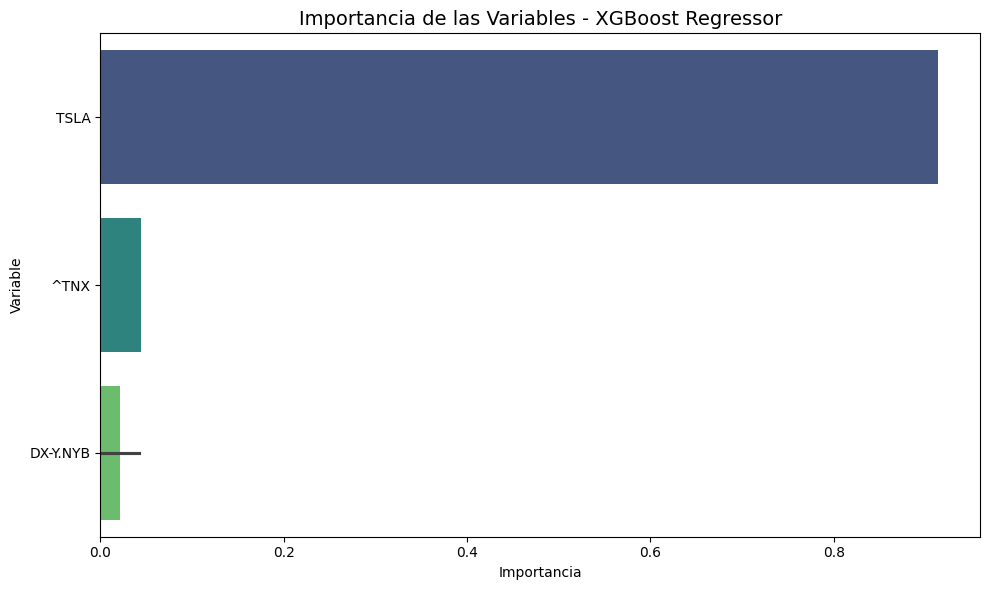

In [ ]:
# Visualización de la importancia de variables por "gain" #
# Obtener importancia de las características #
importancias = best_model.feature_importances_
nombres_variables = X.columns  # usa los nombres originales antes de escalar
indices = np.argsort(importancias)[::-1]

# Crear gráfico #
plt.figure(figsize=(10, 6))
sns.barplot(x=importancias[indices], y=nombres_variables[indices], palette='viridis')
plt.title('Importancia de las Variables - XGBoost Regressor', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

#### 4.2.5. Modelo LSTM

Los modelos LSTM (Long Short-Term Memory), son ideales para predecir series de tiempo financieras como el NASDAQ-100, ya que pueden capturar dependencias a largo plazo y manejar secuencias con memoria.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import GRU, Dense

In [ ]:
# Se selecciona y escala la serie #
serie_ndx = df_close2['^NDX'].dropna().values.reshape(-1, 1)

scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_ndx)

# Convertir a formato supervisado #
def crear_secuencias(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

n_steps = 10  # Se crea una ventana de 10 días
X, y = crear_secuencias(serie_scaled, n_steps)

# Reshape para LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train y test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Construcción del modelo LSTM #
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dense(1)) # Salida
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
65/65 [==============================] - 6s 29ms/step - loss: 0.0075 - val_loss: 0.0014
Epoch 2/100
65/65 [==============================] - 1s 8ms/step - loss: 2.2506e-04 - val_loss: 7.5213e-04
Epoch 3/100
65/65 [==============================] - 0s 7ms/step - loss: 2.0247e-04 - val_loss: 4.3022e-04
Epoch 4/100
65/65 [==============================] - 1s 16ms/step - loss: 1.9266e-04 - val_loss: 4.9801e-04
Epoch 5/100
65/65 [==============================] - 1s 12ms/step - loss: 1.7932e-04 - val_loss: 4.2683e-04
Epoch 6/100
65/65 [==============================] - 0s 7ms/step - loss: 1.7377e-04 - val_loss: 4.3217e-04
Epoch 7/100
65/65 [==============================] - 0s 7ms/step - loss: 1.6891e-04 - val_loss: 3.9824e-04
Epoch 8/100
65/65 [==============================] - 0s 7ms/step - loss: 1.7345e-04 - val_loss: 6.5533e-04
Epoch 9/100
65/65 [==============================] - 0s 7ms/step - loss: 1.6920e-04 - val_loss: 5.5726e-04
Epoch 10/100
65/65 [======================

65/65 [==============================] - 1s 3ms/step


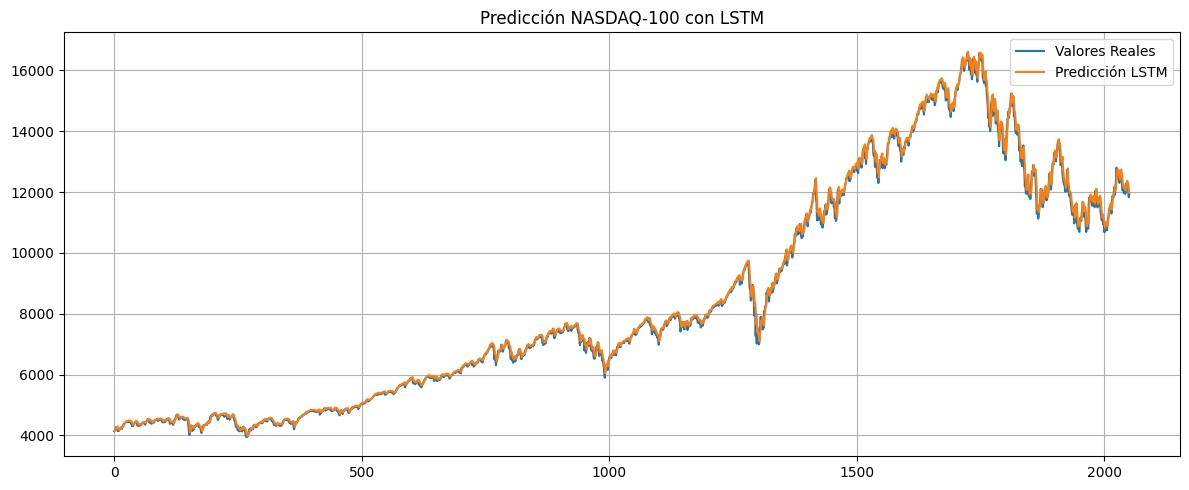

In [ ]:
# Predicciones con el ajuste del modelo - Entrenamiento #
y_pred_scaled_train = model_lstm.predict(X_train)
y_pred_train = scaler.inverse_transform(y_pred_scaled_train.reshape(-1, 1))
y_real_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_train, label='Valores Reales')
plt.plot(y_pred_train, label='Predicción LSTM')
plt.title('Predicción NASDAQ-100 con LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

17/17 [==============================] - 0s 4ms/step


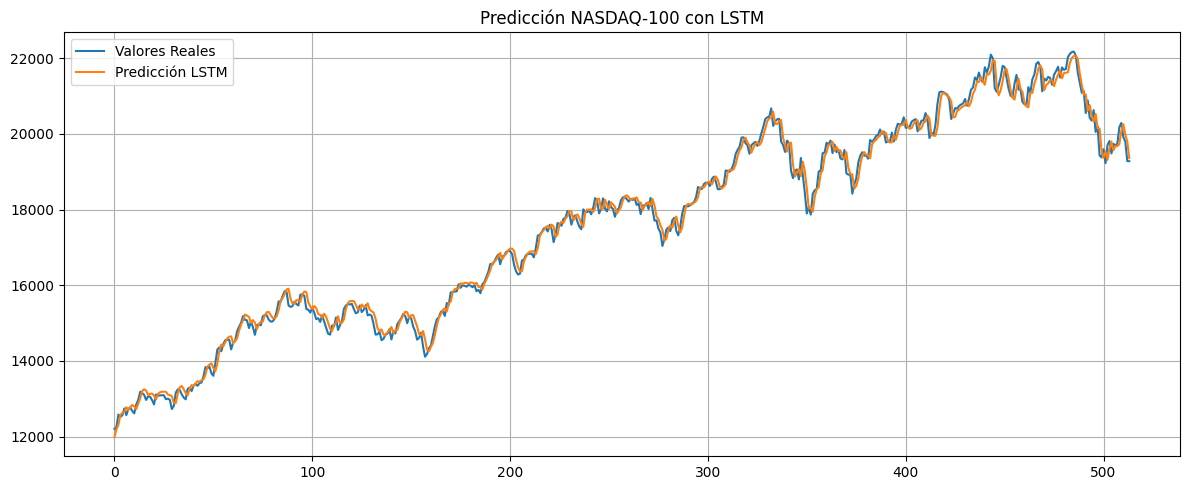

In [ ]:
# Predicciones con el ajuste del modelo #
y_pred_scaled = model_lstm.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualización de predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real, label='Valores Reales')
plt.plot(y_pred, label='Predicción LSTM')
plt.title('Predicción NASDAQ-100 con LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de LSTM:")

# RMSE #
rmse_lstm = mean_squared_error(y_real, y_pred, squared=False)
print(f"RMSE: {rmse_lstm:.4f}")

# MAE #
mae_lstm = mean_absolute_error(y_real, y_pred)
print(f"MAE: {mae_lstm:.4f}")

# R^2 - Entrenamiento #
r2_lstm_train = r2_score(y_real_train, y_pred_train)
print(f"R^2 - Entrenamiento: {r2_lstm_train:.4f}")

# R^2 - Prueba #
r2_lstm_test = r2_score(y_real, y_pred)
print(f"R^2: {r2_lstm_test:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_lstm = {
    "modelo": "LSTM",
    "rmse": rmse_lstm,
    "mae": mae_lstm,
    "r2_train": r2_lstm_train,
    "r2_test": r2_lstm_test,
    "aic": None,
    "bic": None
}

Evaluación del modelo de LSTM:
RMSE: 212.8036
MAE: 163.3390
R^2 - Entrenamiento: 0.9981
R^2: 0.9936


#### 4.2.6. Modelo LSTM Multivariado

Un modelo LSTM multivariado es ideal cuando se quiere predecir una variable objetivo (como el precio del NASDAQ-100) teniendo en cuenta varias series de tiempo como entradas, lo cual refleja mucho mejor la realidad de los mercados financieros.

In [ ]:
# Variables a utilizar #
variables = ["^NDX","TSLA", "^TNX",	"DX-Y.NYB",	"DX-Y.NYB"]
df_multi = df_close2[variables].dropna().asfreq('B').ffill()

# Se escalan todas las series #
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_multi), columns=variables, index=df_multi.index)

# Se crean secuencias multivariadas #
def crear_secuencias_multivariadas(data, target_col='^NDX', ventana=60):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data.iloc[i-ventana:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

ventana = 10
X_mv, y_mv = crear_secuencias_multivariadas(df_scaled, ventana=ventana)

In [ ]:
# División del conjunto en entrenamiento y prueba #
n = len(X_mv)
n_train = int(n * 0.8)

X_train_mv = X_mv[:n_train]
X_test_mv = X_mv[n_train:]
y_train_mv = y_mv[:n_train]
y_test_mv = y_mv[n_train:]

In [ ]:
# Modelo LSTM multivariado #
model_mv = Sequential()
model_mv.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_mv.shape[1], X_train_mv.shape[2])))
model_mv.add(Dense(1))

model_mv.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history_mv = model_mv.fit(X_train_mv, y_train_mv, epochs=100, batch_size=32, validation_data=(X_test_mv, y_test_mv), verbose=1)

Epoch 1/100
67/67 [==============================] - 5s 19ms/step - loss: 0.0269 - val_loss: 0.0437
Epoch 2/100
67/67 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0134
Epoch 3/100
67/67 [==============================] - 1s 8ms/step - loss: 6.0569e-04 - val_loss: 0.0054
Epoch 4/100
67/67 [==============================] - 0s 7ms/step - loss: 2.6564e-04 - val_loss: 0.0030
Epoch 5/100
67/67 [==============================] - 0s 7ms/step - loss: 2.0685e-04 - val_loss: 0.0011
Epoch 6/100
67/67 [==============================] - 1s 9ms/step - loss: 1.9251e-04 - val_loss: 0.0010
Epoch 7/100
67/67 [==============================] - 1s 12ms/step - loss: 1.8250e-04 - val_loss: 0.0013
Epoch 8/100
67/67 [==============================] - 1s 12ms/step - loss: 1.7852e-04 - val_loss: 0.0013
Epoch 9/100
67/67 [==============================] - 1s 12ms/step - loss: 1.7137e-04 - val_loss: 0.0011
Epoch 10/100
67/67 [==============================] - 0s 7ms/step - loss: 1.6

67/67 [==============================] - 2s 5ms/step


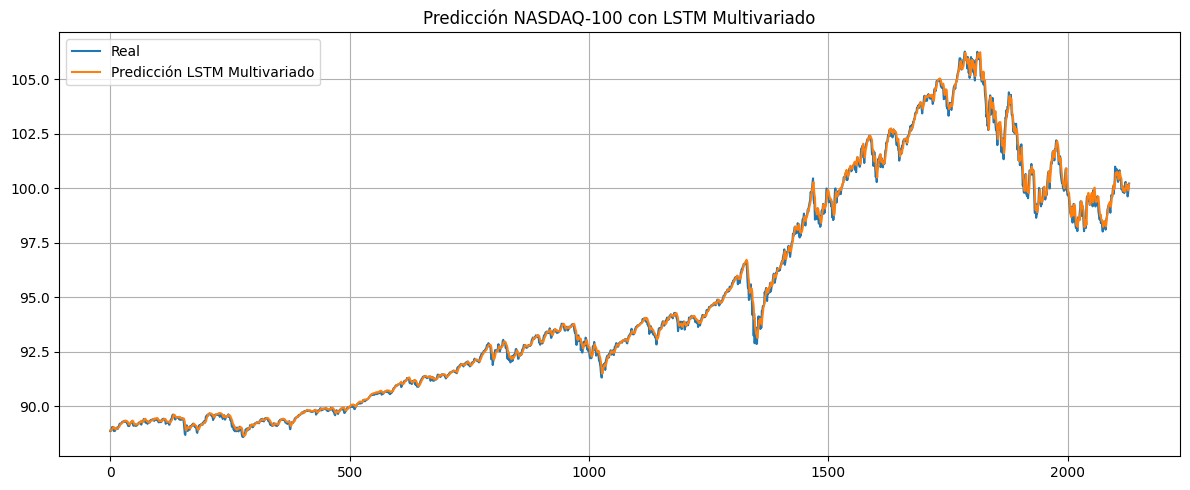

In [ ]:
# Predicción del modelo ajustado - Enrenamiento #
y_pred_mv_scaled_train = model_mv.predict(X_train_mv)
y_pred_mv_train = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_mv_scaled_train), len(variables) - 1)),
        y_pred_mv_scaled_train
    ], axis=1)
)[:, -1]

y_real_mv_train = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_train_mv), len(variables) - 1)),
        y_train_mv.reshape(-1, 1)
    ], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_mv_train, label='Real')
plt.plot(y_pred_mv_train, label='Predicción LSTM Multivariado')
plt.title('Predicción NASDAQ-100 con LSTM Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

17/17 [==============================] - 0s 3ms/step


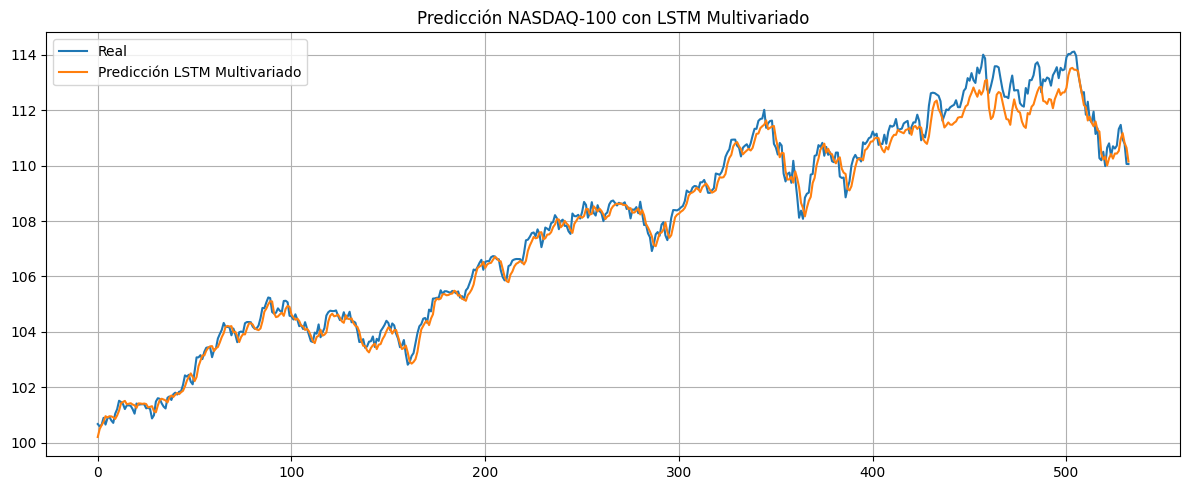

In [ ]:
# Predicción del modelo ajustado #
y_pred_mv_scaled = model_mv.predict(X_test_mv)
y_pred_mv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_mv_scaled), len(variables) - 1)),
        y_pred_mv_scaled
    ], axis=1)
)[:, -1]

y_real_mv = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_test_mv), len(variables) - 1)),
        y_test_mv.reshape(-1, 1)
    ], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_mv, label='Real')
plt.plot(y_pred_mv, label='Predicción LSTM Multivariado')
plt.title('Predicción NASDAQ-100 con LSTM Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo de LSTM Multivariado:")

# RMSE #
rmse_mv = np.sqrt(mean_squared_error(y_real_mv, y_pred_mv))
print(f"RMSE: {rmse_mv:.4f}")

# MAE #
mae_mv = mean_absolute_error(y_real_mv, y_pred_mv)
print(f"MAE: {mae_mv:.4f}")

# R^2 - Entrenamiento #
r2_mv_train = r2_score(y_real_mv_train, y_pred_mv_train)
print(f"R^2 - Test: {r2_mv_train:.4f}")

# R^2 - Prueba #
r2_mv_test = r2_score(y_real_mv, y_pred_mv)
print(f"R^2 - Train: {r2_mv_test:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_lstm_multi = {
    "modelo": "LSTM Multivariado",
    "rmse": rmse_mv,
    "mae": mae_mv,
    "r2_train": r2_mv_train,
    "r2_test": r2_mv_test,
    "aic": None,
    "bic": None
}

Evaluación del modelo de LSTM Multivariado:
RMSE: 0.4190
MAE: 0.3144
R^2 - Test: 0.9982
R^2 - Train: 0.9872


#### 4.2.7. Modelo GRU Multivariado

Por último, se preparará el modelado completo del GRU multivariado tal como se hizo con LSTM, para mantener la coherencia en la metodología.

In [ ]:
# Variables seleccionadas #
variables = ["^NDX","TSLA", "^TNX",	"DX-Y.NYB"]
df_gru = df_close2[variables].dropna().asfreq('B').ffill()

# Se escalan todas las series #
scaler = MinMaxScaler()
df_scaled_gru = pd.DataFrame(scaler.fit_transform(df_gru), columns=variables, index=df_gru.index)

# Se crean secuencias multivariadas #
def crear_secuencias_multivariadas(data, target_col='^NDX', ventana=60):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data.iloc[i-ventana:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)

ventana = 10
X_gru, y_gru = crear_secuencias_multivariadas(df_scaled_gru, ventana=ventana)

In [ ]:
# Se divide el conjunto en entrenamiento y prueba #
n = len(X_gru)
n_train = int(n * 0.8)

X_train_gru = X_gru[:n_train]
X_test_gru = X_gru[n_train:]
y_train_gru = y_gru[:n_train]
y_test_gru = y_gru[n_train:]

In [ ]:
# Construcción y entrenamiento del modelo GRU #
# Se define el modelo GRU #
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=False, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo #
history_gru = model_gru.fit(X_train_gru, y_train_gru, epochs=100, batch_size=32, validation_data=(X_test_gru, y_test_gru), verbose=1)

Epoch 1/100
67/67 [==============================] - 6s 29ms/step - loss: 0.0071 - val_loss: 0.0281
Epoch 2/100
67/67 [==============================] - 1s 11ms/step - loss: 7.0506e-04 - val_loss: 0.0100
Epoch 3/100
67/67 [==============================] - 1s 13ms/step - loss: 2.0434e-04 - val_loss: 0.0028
Epoch 4/100
67/67 [==============================] - 1s 15ms/step - loss: 1.0564e-04 - val_loss: 0.0017
Epoch 5/100
67/67 [==============================] - 1s 18ms/step - loss: 9.8950e-05 - val_loss: 0.0013
Epoch 6/100
67/67 [==============================] - 1s 18ms/step - loss: 9.4709e-05 - val_loss: 0.0016
Epoch 7/100
67/67 [==============================] - 1s 17ms/step - loss: 1.0205e-04 - val_loss: 0.0012
Epoch 8/100
67/67 [==============================] - 1s 14ms/step - loss: 1.0655e-04 - val_loss: 0.0013
Epoch 9/100
67/67 [==============================] - 1s 13ms/step - loss: 9.3213e-05 - val_loss: 9.0481e-04
Epoch 10/100
67/67 [==============================] - 1s 12ms/st

67/67 [==============================] - 1s 2ms/step


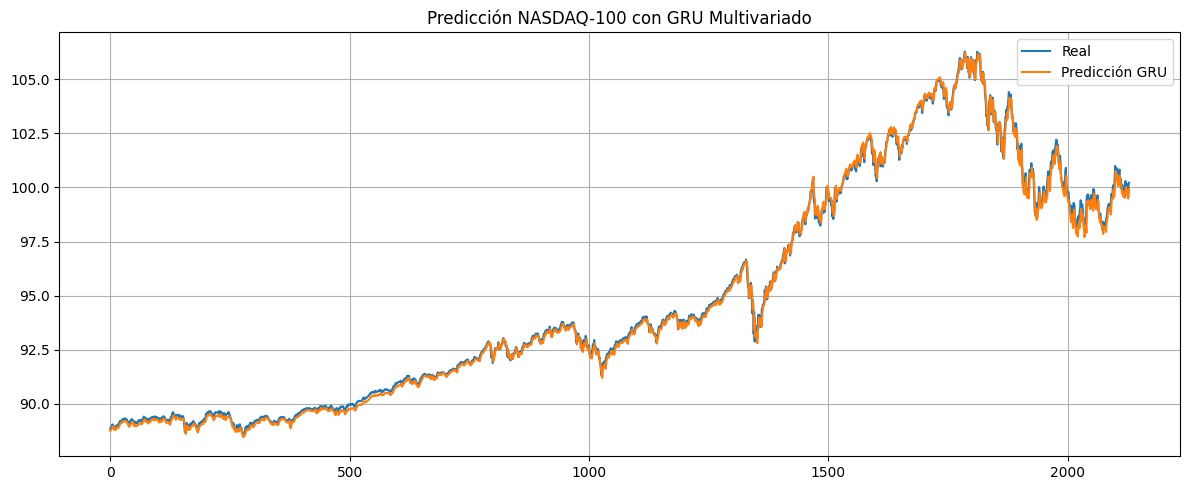

In [ ]:
# Se calculan las predicciones del modelo #
y_pred_gru_scaled_train = model_gru.predict(X_train_gru)

# Inversión del escalado SOLO para la columna target (^NDX) #
y_pred_gru_train = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred_gru_scaled_train), len(variables)-1)), y_pred_gru_scaled_train], axis=1)
)[:, -1]

y_real_gru_train = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_train_gru), len(variables)-1)), y_train_gru.reshape(-1,1)], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_gru_train, label='Real')
plt.plot(y_pred_gru_train, label='Predicción GRU')
plt.title('Predicción NASDAQ-100 con GRU Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

17/17 [==============================] - 0s 3ms/step


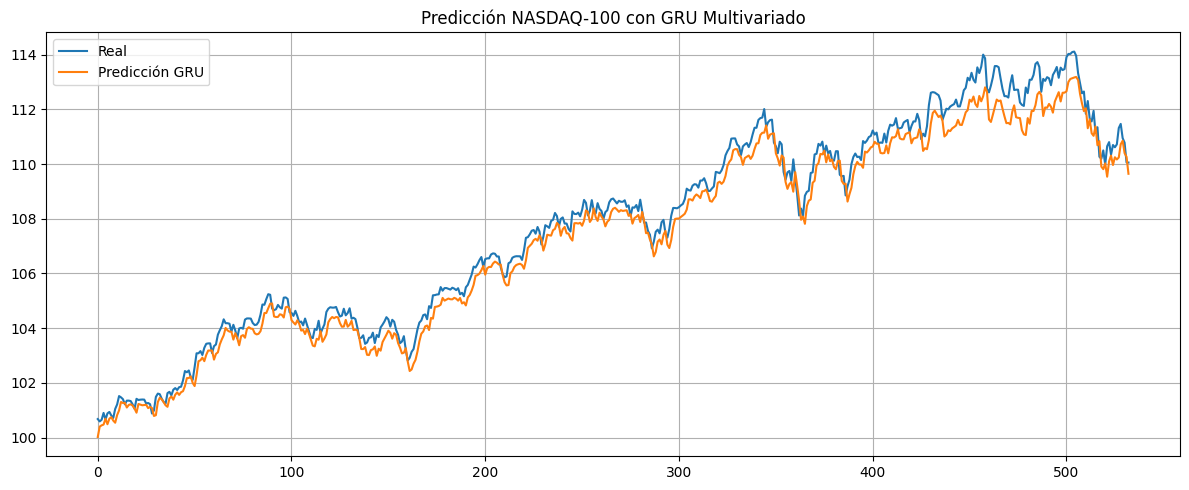

In [ ]:
# Se calculan las predicciones del modelo #
y_pred_gru_scaled = model_gru.predict(X_test_gru)

# Inversión del escalado SOLO para la columna target (^NDX) #
y_pred_gru = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred_gru_scaled), len(variables)-1)), y_pred_gru_scaled], axis=1)
)[:, -1]

y_real_gru = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_test_gru), len(variables)-1)), y_test_gru.reshape(-1,1)], axis=1)
)[:, -1]

# Visualización de las predicciones #
plt.figure(figsize=(12, 5))
plt.plot(y_real_gru, label='Real')
plt.plot(y_pred_gru, label='Predicción GRU')
plt.title('Predicción NASDAQ-100 con GRU Multivariado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo #
print(f"Evaluación del modelo GRU Multivariado:")

# RMSE #
rmse_gru = np.sqrt(mean_squared_error(y_real_gru, y_pred_gru))
print(f"RMSE: {rmse_gru:.4f}")

# MAE #
mae_gru = mean_absolute_error(y_real_gru, y_pred_gru)
print(f"MAE: {mae_gru:.4f}")

# R^2 - Entrenamiento #
r2_gru_train = r2_score(y_real_gru_train, y_pred_gru_train)
print(f"R^2 - Train: {r2_gru_train:.4f}")

# R^2 - Prueba #
r2_gru_test = r2_score(y_real_gru, y_pred_gru)
print(f"R^2 - Test: {r2_gru_test:.4f}")

# AIC y BIC no tiene en XGBoost #

# Se guardan los resultados #
resultados_gru = {
    "modelo": "GRU Multivariado",
    "rmse": rmse_gru,
    "mae": mae_gru,
    "r2_train": r2_gru_train,
    "r2_test": r2_gru_test,
    "aic": None,
    "bic": None
}

Evaluación del modelo GRU Multivariado:
RMSE: 0.5790
MAE: 0.4823
R^2 - Train: 0.9980
R^2 - Test: 0.9756


## 5. Comparación de resultados de modelos (Evaluación)

In [ ]:
# Se consolidan los resultados en un DataFrame #
resultados_modelos = [resultados_ARIMA, resultados_ARIMAX, resultados_SARIMA, resultados_GARCH,
                      resultados_reg_lineal, resultados_rl_multi, resultados_rf, resultados_xgb,
                      resultados_lstm, resultados_lstm_multi, resultados_gru]
df_resultados = pd.DataFrame(resultados_modelos)
columnas_orden = ['modelo', 'rmse', 'mae', 'r2_train', 'r2_test', 'aic', 'bic']
df_resultados = df_resultados[columnas_orden]

print("Comparación de modelos:")
print(df_resultados)

# Exportar a Excel o CSV (se hará luego) #
# df_resultados.to_csv("comparacion_modelos.csv", index=False)

Comparación de modelos:
                       modelo         rmse          mae  r2_train   r2_test  \
0                ARIMA(1,1,1)   206.992564   154.030487 -0.000064 -0.002682   
1               ARIMAX(1,1,1)   165.685676   127.983387  0.366056  0.357573   
2     SARIMA(1,1,1,21)(1,1,1)   208.212593   155.662342 -0.016530 -0.014536   
3                  GARCH(1,1)   146.419334   122.949474 -4.096260 -0.124828   
4     Regresión Lineal simple   203.402219   149.257133  0.998522  0.994169   
5   Regresión Lineal Múltiple  5945.808890  5445.069528  0.863951 -3.982665   
6               Random Forest  5950.471315  5350.986891  0.995552 -3.990483   
7                     XGBoost  5881.853624  5297.574200  0.988039 -3.820194   
8                        LSTM   212.803604   163.339031  0.998139  0.993603   
9           LSTM Multivariado     0.418961     0.314443  0.998229  0.987230   
10           GRU Multivariado     0.578960     0.482349  0.998006  0.975615   

             aic           

In [ ]:
# Se muestran los 3 mejores modelos según cada métrica #
print("Top 3 modelos con menor RMSE:")
print(df_resultados.sort_values('rmse').head(3)[['modelo', 'rmse']])

print("Top 3 modelos con menor MAE:")
print(df_resultados.sort_values('mae').head(3)[['modelo', 'mae']])

print("Top 3 modelos con mayor R^2_train:")
print(df_resultados.sort_values('r2_train', ascending=False).head(3)[['modelo', 'r2_train']])


print("Top 3 modelos con mayor R^2_test:")
print(df_resultados.sort_values('r2_test', ascending=False).head(3)[['modelo', 'r2_test']])

# Selección basada en múltiple criterio: priorizamos menor RMSE y mayor R²
mejor_modelo = df_resultados.loc[df_resultados['rmse'].idxmin()]
print("Mejor modelo según menor RMSE:")
print(mejor_modelo)

# Opción adicional: ponderación de métricas (RMSE, MAE, R2)
# Normalizamos las métricas para combinarlas
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_metrics = scaler.fit_transform(df_resultados[['rmse', 'mae', 'r2_train', 'r2_test']])
score = scaled_metrics[:, 0] + scaled_metrics[:, 1] - scaled_metrics[:, 2]  # menor score = mejor modelo
df_resultados['composite_score'] = score

print("Mejor modelo según métrica compuesta (RMSE + MAE - R²):")
print(df_resultados.loc[df_resultados['composite_score'].idxmin()])


Top 3 modelos con menor RMSE:
               modelo        rmse
9   LSTM Multivariado    0.418961
10   GRU Multivariado    0.578960
3          GARCH(1,1)  146.419334
Top 3 modelos con menor MAE:
               modelo         mae
9   LSTM Multivariado    0.314443
10   GRU Multivariado    0.482349
3          GARCH(1,1)  122.949474
Top 3 modelos con mayor R^2_train:
                    modelo  r2_train
4  Regresión Lineal simple  0.998522
9        LSTM Multivariado  0.998229
8                     LSTM  0.998139
Top 3 modelos con mayor R^2_test:
                    modelo   r2_test
4  Regresión Lineal simple  0.994169
8                     LSTM  0.993603
9        LSTM Multivariado  0.987230
Mejor modelo según menor RMSE:
modelo      LSTM Multivariado
rmse                 0.418961
mae                  0.314443
r2_train             0.998229
r2_test               0.98723
aic                       NaN
bic                       NaN
Name: 9, dtype: object
Mejor modelo según métrica compuesta (RM